# Blue Horizontal Branch Stars
## MSP, 23.5.2019

Cleaned Notebook to analyse Blue Horizontal Branch data

## Steps

1. Read in Xue 2008, 2011 catalog
2. Think about satellite disruption and dynamics



In [ ]:
# the master list of definitions

import reflexmotion as rm

In [1]:
# standard python modules
import numpy as np;import time;import copy

# plotting utilities
import matplotlib.pyplot as plt;import matplotlib as mpl;import matplotlib.cm as cm;import matplotlib.colors as colors
%matplotlib inline

cmap = mpl.cm.inferno


import scipy.interpolate as interpolate;import subprocess;from astropy.io import fits

In [2]:
# exptool imports
from exptool.basis import eof;from exptool.basis import spheresl;from exptool.basis import *

from ssl import *;from exptool.io import psp_io

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

from exptool.utils import *

stylepar='medium'

if stylepar == 'medium':
    mpl.rcParams['font.weight'] = 'medium'
    mpl.rcParams['axes.linewidth'] = 1.5
    mpl.rcParams['xtick.major.width'] = 1.5
    mpl.rcParams['xtick.minor.width'] = 0.75
    mpl.rcParams['xtick.minor.visible'] = True
    mpl.rcParams['ytick.major.width'] = 1.5
    mpl.rcParams['ytick.minor.width'] = 0.75
    mpl.rcParams['ytick.minor.visible'] = True







In [3]:
# follow along here

# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py

import astropy.coordinates as coord
import astropy.units as u

The Xue+ 2011 sample consists of ∼4000 objects drawn from SDSS DR8 (Eisenstein et al. 2011) that pass both the colour cuts of Yanny et al. (2000) and the two Balmer-line profile cuts already described in Xue et al. (2008), but here slightly relaxed (see Xue et al. 2011). We retrieve these objects in DR9 and adopt the latter values for both their physical parameters and their astrometry.



Following the methodology in Deason et al. (2018), we begin with the blue horizontal branch sample of Xue et al. (2011). Drawn from the spectroscopic sample of SEGUE stars, the BHBs are identified via a color cut and Balmer-line profile cuts, as described in Xue et al. (2011), with references to Yanny et al. (2000) and Xue et al. (2008).

In [5]:
# now use the the color and metallicity dependent 
# absolute magnitude relation derived by Fermani & Schönrich (2013)

def fs_mag(gr,feh):
    """use equation 5 of fermani & schonrich 2013 to get the absolute G magnitude
    """
    
    gvals = 0.0075 * np.exp(-14.*gr) + 0.04 * (feh + 3.5)**2. + 0.25
    
    gvals[feh<-5.] = np.nan

    return gvals
    
    
    

In [34]:
#RAJ2000;DEJ2000;GLON;GLAT;gmag;u-g;D0.2;fm;cHg;bHg;d;r;x;y;z;HRV;e_HRV;Vgal;DR8;Sloan;SimbadName


X11 = np.genfromtxt('data/Xue2011BHB.txt',\
                        dtype={'names': ("RA","Dec","Glon","Glat",\
                                         "gmag","ug","gr","D02","fm",\
                                         "cHg","bHg","d","r",\
                                         "x","y","z","HRV",\
                                         "eHRV","Vgal","DR8","Sloan",\
                                         "SimbadName"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'S20')},\
                 skip_header=77,delimiter=';')


# hand-make the matching table
f = open('data/matchingbhb.txt','w')

print('name ra  dec',file=f)

for x in range(0,len(X11['RA'])):
    print('S'+str(x),X11['RA'][x],X11['Dec'][x],file=f)

f.close()

# match BHBs against the SDSS spectra
X11m = np.genfromtxt('data/Xue2011BHBxmatch.txt',\
                        dtype={'names': ("Name","specobjid","ra","dec",\
                                         "plate","mjd","fiberid","fehadop",\
                                        "fehadopunc","elodiervfinal","elodiervfinalerr",\
                                         "fehspec","fehspecunc","psfg","fibreg"),\
                             'formats': ('S20','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8',\
                                        'f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')




GmatchO = np.genfromtxt('data/Xue2011BHBxmatch_gaia.txt',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')

Gmatch = np.genfromtxt('data/Xue2011BHBxmatch_gaia_corr.txt',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmcorr","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')

# there is a uniqueness problem that requires additional matching.

In [39]:
# hand-make the crossmatches


# need to double check all this matching...something doesn't seem right.
decoded_names = np.array([int((X11m['Name'][x].decode()).strip('S')) for x in range(0,X11m['Name'].size)])

# do the cross-matching to the original Xue sample
# everything is therefore matched to the X11 sample


# can take all the X11 data
grvals = X11["gr"]


gaiadict = {}

matchlist = ["gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmcorr","dist"]

for match in matchlist:
    gaiadict['g'+match] = np.zeros(grvals.size)
    

sdss_list = ["specobjid","ra","dec",\
                                         "plate","mjd","fiberid","fehadop",\
                                        "fehadopunc","elodiervfinal","elodiervfinalerr",\
                                         "fehspec","fehspecunc","psfg","fibreg"]

for match in sdss_list:
    gaiadict['s'+match] = np.zeros(grvals.size)
    


# this performs the matching. loop over each source...
for indx,val in enumerate(decoded_names):
    
    # add the sdss data, identified by decoded name
    for match in sdss_list:
        gaiadict['s'+match][val] = X11m[match][indx]
    
    # add the gaia data
    try:
        for match in matchlist:
            # identify by matching the name down the list.
            gaiadict['g'+match][val] = Gmatch[match][Gmatch['xsource_id']==X11m['Name'][indx]]
    except:
        print('Failure')
    




Failure
Failure
Failure
Failure
Failure
Failure


In [40]:
# set the magnitude limit
#keep = np.where(gaiag < 17.2)
#keep = np.where(psfg < 17.2)
#keep = np.where((X11['gmag'] < 17.0) & (X11['gr'] > -0.4) & (np.isnan(pmr)!=True)\
#                & (fehvals > -3.) & (np.isnan(radval)!=True) & (np.abs(raval-X11['RA'])<0.1))

#keep = np.where((X11['gmag'] < 19.0) & (X11['gr'] > -0.4) & (np.isnan(pmr)!=True)\
#                & (fehvals > -3.) & (np.isnan(radval)!=True) & (np.abs(raval-X11['RA'])<0.1))

# keep all!
keep = np.where(gaiadict['gphot_g_mean_mag'])

print(keep[0].size)




4944


(array([93]),)


Text(0.5, 1.0, 'RUWE for stars at $>$50 kpc')

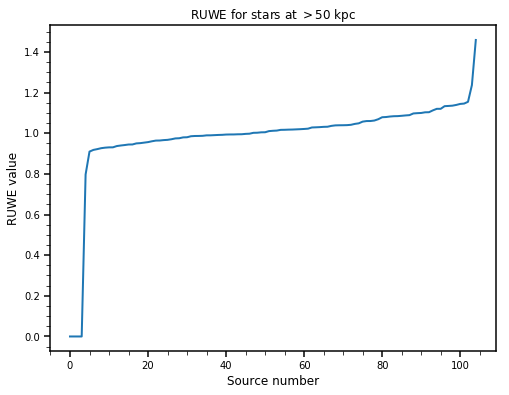

In [41]:
# append RUWE data

RU = np.genfromtxt('data/Xue2011BHB_xmatch_gaia_ruwe.txt',skip_header=1,delimiter=',')

gaiadict['gruwe'] = np.zeros(gaiadict['gpmdec_error'].size)

for i in range(0,gaiadict['gpmdec_error'].size):
    try:
        #print(RU[gaiadict['gpmdec_error'][i]==RU[:,0],0],gaiadict['gpmdec_error'][i])
        gaiadict['gruwe'][i] = RU[gaiadict['gpmdec_error'][i]==RU[:,0],23]
    except:
        pass
    #print(RU[i,23],gaiadict['gdec'][gaiadict['gpmdec_error']==RU[i,0]])
    

distsize = gaiadict['gruwe'][X11['d']>50]

print(np.where(distsize>1.4))

plt.plot(distsize[distsize.argsort()])

plt.xlabel('Source number',size=12)
plt.ylabel('RUWE value',size=12)
plt.title('RUWE for stars at $>$50 kpc',size=12)

Text(0.5, 1.0, 'Correlation for stars at $>$50 kpc')

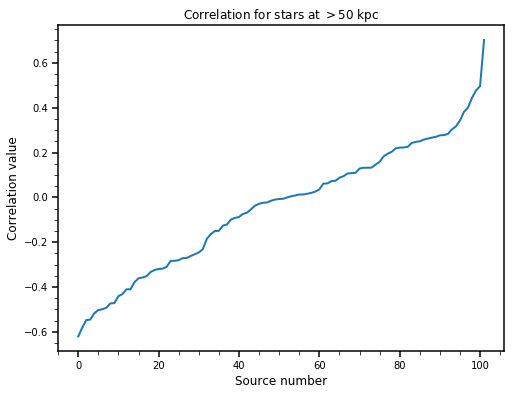

In [42]:
# check how strong the velocity correlations are
distsize = gaiadict['gpmcorr'][X11['d']>50]

plt.plot(distsize[distsize.argsort()])

plt.xlabel('Source number',size=12)
plt.ylabel('Correlation value',size=12)
plt.title('Correlation for stars at $>$50 kpc',size=12)

[]
[219]


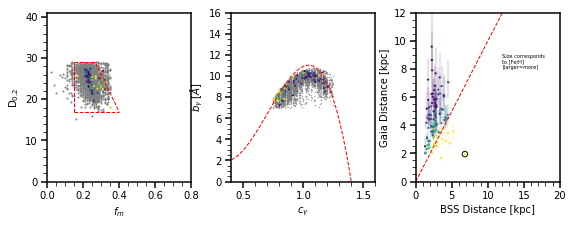

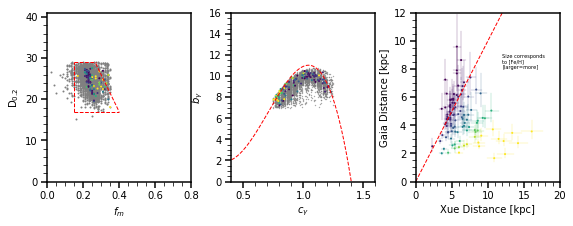

In [16]:
mval = gaiadict['sfehadop'][w]
mval[mval<-5.] = -2.5
print(mval)
#plt.plot(mval[mval.argsort()])


def bss_mag(gr):
    return 3.108 + 5.495*gr

Gmag = bss_mag(X11['gr'])

bssdist = 10.**((X11['gmag']-Gmag+5.)/5.-3.)




fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.1,0.17,0.25,0.78])
ax2 = fig.add_axes([0.42,0.17,0.25,0.78])
ax3 = fig.add_axes([0.74,0.17,0.25,0.78])

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

drat = X11['d']*gaiadict['gparallax']
w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5)[0]

mvalsize = 6.*(mval+2.5)

ax1.scatter(X11['fm'],X11["D02"],color='gray',s=1.)
ax1.scatter(X11['fm'][w],X11["D02"][w],color=cm.viridis((drat[w]-0.8)/2.,1.),s=mvalsize)

def draw_d_fm_polygon(ax):
    """draw santucci BSS polygon
    
    default color and linestyles only...
    """
    color='red'
    linestyle='dashed'
    lw=1.
    ax.plot([0.15,0.27],[29.,29.],color=color,linestyle=linestyle,lw=lw)
    ax.plot(np.linspace(0.27,0.40,100),-90.*np.linspace(0.27,0.40,100)+53.,color=color,linestyle=linestyle,lw=lw)
    ax.plot([0.15,0.4],[17.,17.],color=color,linestyle=linestyle,lw=lw)
    ax.plot([0.15,0.15],[17.,29.],color=color,linestyle=linestyle,lw=lw)


draw_d_fm_polygon(ax1)


ax1.set_xlabel('$f_m$',size=10)
ax1.set_ylabel('D$_{0.2}~[\AA]$',size=10)
ax1.axis([0.,0.8,0.,41.])

ax2.scatter(X11['cHg'],X11["bHg"],color='gray',s=0.1)
ax2.scatter(X11['cHg'][w],X11["bHg"][w],color=cm.viridis((drat[w]-0.8)/2.,1.),s=mvalsize)

def b_c_relation(c):
    """santucci 2014 cutoff for BHB and BS stars"""
    return 9.20 - 46.32*c + 82.24*c*c - 23.36*c*c*c - 10.82*c*c*c*c

crange = np.linspace(0.4,1.6,1000)
ax2.plot(crange,b_c_relation(crange),color='red',linestyle='dashed',lw=1.)

ax2.set_xlabel('$c_\gamma$',size=10)
ax2.set_ylabel('$b_\gamma$ $[\AA]$',size=10)
ax2.axis([0.4,1.6,0,16])

#w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5.)[0]
#ax3.scatter(X11['d'][w],1./gaiadict['gparallax'][w],s=mvalsize,color=cm.viridis((drat[w]-0.8)/2.,1.))
ax3.scatter(bssdist[w],1./gaiadict['gparallax'][w],s=mvalsize,color=cm.viridis((drat[w]-0.8)/2.,1.))


for i in w:
    ax3.plot([bssdist[i],bssdist[i]],\
             [1./(gaiadict['gparallax'][i]-gaiadict['gparallax_error'][i]),\
              1./(gaiadict['gparallax'][i]+gaiadict['gparallax_error'][i])],\
              lw=0.25,color=cm.viridis((drat[i]-0.8)/2.,1.))
    ax3.plot([bssdist[i]*1.10,bssdist[i]*0.91],\
             [1./gaiadict['gparallax'][i],1./gaiadict['gparallax'][i]],lw=0.25,color=cm.viridis((drat[i]-0.8)/2.,1.))


ax3.plot([0.,30.],[0.,30.],color='red',linestyle='dashed',lw=1.)

# add the RUWE
ww = np.where( ((gaiadict['gparallax']/gaiadict['gparallax_error'])>5.) & (gaiadict['gruwe']>1.4))[0]
print(ww)
ax3.scatter(bssdist[ww],1./gaiadict['gparallax'][ww],s=30.,edgecolor='black',facecolor='none')




ax3.axis([0.,20.,0.,12.])
ax3.set_xlabel('BSS Distance [kpc]',size=10)
ax3.set_ylabel('Gaia Distance [kpc]',size=10)
#ax3.text(12.,8.,'Size corresponds\nto extinction\n[larger=more]',size=5)
ax3.text(12.,8.,'Size corresponds\nto [Fe/H]\n[larger=more]',size=5)





plt.savefig('figures/comp_bss_metal.png',dpi=300)






fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.1,0.17,0.25,0.78])
ax2 = fig.add_axes([0.42,0.17,0.25,0.78])
ax3 = fig.add_axes([0.74,0.17,0.25,0.78])

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

drat = X11['d']*gaiadict['gparallax']
w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5)[0]

mvalsize = 6.*(mval+2.5)

ax1.scatter(X11['fm'],X11["D02"],color='gray',s=1.)
ax1.scatter(X11['fm'][w],X11["D02"][w],color=cm.viridis((drat[w]-0.8)/2.,1.),s=mvalsize)

def draw_d_fm_polygon(ax):
    """draw santucci BSS polygon
    
    default color and linestyles only...
    """
    color='red'
    linestyle='dashed'
    lw=1.
    ax.plot([0.15,0.27],[29.,29.],color=color,linestyle=linestyle,lw=lw)
    ax.plot(np.linspace(0.27,0.40,100),-90.*np.linspace(0.27,0.40,100)+53.,color=color,linestyle=linestyle,lw=lw)
    ax.plot([0.15,0.4],[17.,17.],color=color,linestyle=linestyle,lw=lw)
    ax.plot([0.15,0.15],[17.,29.],color=color,linestyle=linestyle,lw=lw)


draw_d_fm_polygon(ax1)


ax1.set_xlabel('$f_m$',size=10)
ax1.set_ylabel('D$_{0.2}~[\AA]$',size=10)
ax1.axis([0.,0.8,0.,41.])

ax2.scatter(X11['cHg'],X11["bHg"],color='gray',s=0.1)
ax2.scatter(X11['cHg'][w],X11["bHg"][w],color=cm.viridis((drat[w]-0.8)/2.,1.),s=mvalsize)

def b_c_relation(c):
    """santucci 2014 cutoff for BHB and BS stars"""
    return 9.20 - 46.32*c + 82.24*c*c - 23.36*c*c*c - 10.82*c*c*c*c

crange = np.linspace(0.4,1.6,1000)
ax2.plot(crange,b_c_relation(crange),color='red',linestyle='dashed',lw=1.)

ax2.set_xlabel('$c_\gamma$',size=10)
ax2.set_ylabel('$b_\gamma~[\AA]$',size=10)
ax2.axis([0.4,1.6,0,16])

#w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5.)[0]
ax3.scatter(X11['d'][w],1./gaiadict['gparallax'][w],s=mvalsize,color=cm.viridis((drat[w]-0.8)/2.,1.))

for i in w:
    ax3.plot([X11['d'][i],X11['d'][i]],\
             [1./(gaiadict['gparallax'][i]-gaiadict['gparallax_error'][i]),\
              1./(gaiadict['gparallax'][i]+gaiadict['gparallax_error'][i])],\
              lw=0.25,color=cm.viridis((drat[i]-0.8)/2.,1.))
    ax3.plot([X11['d'][i]*1.10,X11['d'][i]*0.91],\
             [1./gaiadict['gparallax'][i],1./gaiadict['gparallax'][i]],lw=0.25,color=cm.viridis((drat[i]-0.8)/2.,1.))


ax3.plot([0.,30.],[0.,30.],color='red',linestyle='dashed',lw=1.)

ax3.axis([0.,20.,0.,12.])
ax3.set_xlabel('Xue Distance [kpc]',size=10)
ax3.set_ylabel('Gaia Distance [kpc]',size=10)
#ax3.text(12.,8.,'Size corresponds\nto extinction\n[larger=more]',size=5)
ax3.text(12.,8.,'Size corresponds\nto [Fe/H]\n[larger=more]',size=5)





plt.savefig('figures/comp_bhb_metal.png',dpi=300)



Text(0, 0.5, 'Median Uncertainty')

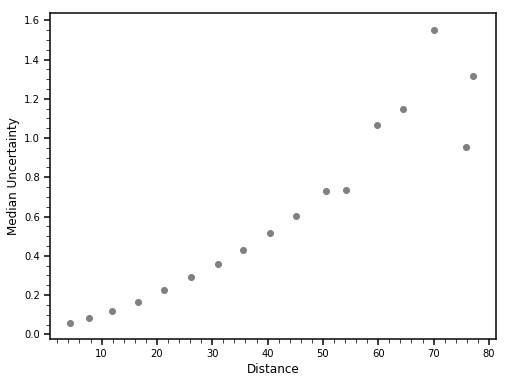

In [13]:

dist = X11['d']
signoise = np.sqrt(gaiadict['gpmdec_error']*gaiadict['gpmdec_error'] + np.cos(gaiadict['gdec'])*np.cos(gaiadict['gdec'])*gaiadict['gpmra_error']*gaiadict['gpmra_error'])

dbins = 20

binvals = np.linspace(0.,91.,dbins)


f = open('processed/bhbsignnoise.txt','w')
for b in range(0,dbins):
    if b==dbins-1:
        maxval = np.inf
    else:
        maxval = binvals[b+1]
    w = np.where((dist>binvals[b])&(dist<maxval))
    if b!=dbins-2:
        plt.scatter(np.nanmedian(dist[w]),\
                np.nanmedian(signoise[w]),\
               color='gray')   
    
        print(np.nanmedian(dist[w]),
          np.nanmedian(signoise[w]),file=f)
    
f.close()

plt.xlabel('Distance',size=12)
plt.ylabel('Median Uncertainty',size=12)

In [57]:
c.galactic

#(pm_l_cosb, pm_b)

<SkyCoord (Galactic): (l, b) in deg
    [( 66.46835646, -36.49371587), ( 61.15107188,  46.72996385),
     (353.34638802,  61.47764698), ( 72.45202665,  46.68857375),
     ( 65.02480429,  40.37141828), (321.87250917,  62.30010962),
     (356.40402669,  49.84243995), (355.25317238,  49.68761435),
     ( 70.41488945,  59.91252046), (139.04574118,  52.43878895),
     (109.97630196,  62.20937446), (232.41344327,  67.22246776),
     (232.14174669,  67.78274809), ( 84.0270334 ,  80.86251445),
     ( 48.07161543,  67.9412906 ), (269.90083785,  85.16944754),
     ( 12.93517076,  56.42300861), ( 10.0093275 ,  55.8638628 ),
     (  9.00708454,  56.46432723), ( 63.13780777,  67.55312263),
     ( 14.39948522,  80.82506371), ( 66.74473728,  37.81454004),
     ( 12.7539381 ,  46.92933566), (221.86150688,  39.08631033),
     (222.9873006 ,  40.6789679 ), (148.80154926,  33.96370915),
     ( 96.13880855,  55.36301669), (226.22645196,  59.10701893),
     (151.60890593,  39.41680416), (194.41824154,  24.

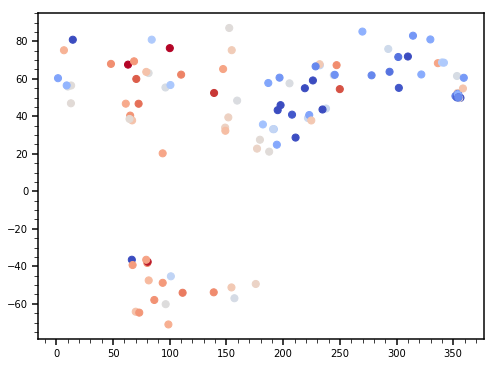

In [56]:
c = coord.SkyCoord(ra=gaiadict['gra'][bigd]*u.deg,\
                   dec=gaiadict['gdec'][bigd]*u.deg,\
                   pm_ra_cosdec=gaiadict['gpmra'][bigd]*u.mas/u.yr,\
                   pm_dec=gaiadict['gpmdec'][bigd]*u.mas/u.yr)


plt.scatter(np.array(c.galactic.l),np.array(c.galactic.b),color=cm.coolwarm((gaiadict['gpmcorr'][bigd]+0.5),1.),s=50.)

In [48]:
gaiadict.keys()

dict_keys(['ggsource_id', 'gra', 'gra_error', 'gdec', 'gdec_error', 'gparallax', 'gparallax_error', 'gpmra', 'gpmra_error', 'gpmdec', 'gpmdec_error', 'gphot_g_mean_flux', 'gphot_g_mean_flux_error', 'gphot_g_mean_mag', 'gphot_bp_mean_flux', 'gphot_bp_mean_flux_error', 'gbp_rp', 'gradial_velocity', 'gradial_velocity_error', 'gphot_variable_flag', 'gteff_val', 'ga_g_val', 'gpmcorr', 'gdist', 'sspecobjid', 'sra', 'sdec', 'splate', 'smjd', 'sfiberid', 'sfehadop', 'sfehadopunc', 'selodiervfinal', 'selodiervfinalerr', 'sfehspec', 'sfehspecunc', 'spsfg', 'sfibreg', 'gruwe'])

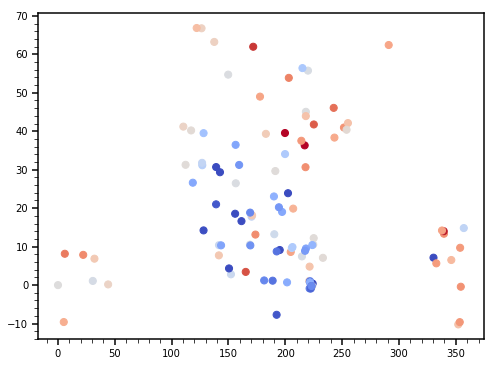

In [45]:
bigd = [X11['d']>50]

plt.scatter(gaiadict['gra'][bigd],gaiadict['gdec'][bigd],color=cm.coolwarm((gaiadict['gpmcorr'][bigd]+0.5),1.),s=50.)

In [ ]:
c = coord.SkyCoord(ra=62*u.deg,\
                   dec=17*u.deg,\
                   pm_ra_cosdec=1*u.mas/u.yr,\
                   pm_dec=3*u.mas/u.yr)



In [63]:
gaiadict.keys()

dict_keys(['ggsource_id', 'gra', 'gra_error', 'gdec', 'gdec_error', 'gparallax', 'gparallax_error', 'gpmra', 'gpmra_error', 'gpmdec', 'gpmdec_error', 'gphot_g_mean_flux', 'gphot_g_mean_flux_error', 'gphot_g_mean_mag', 'gphot_bp_mean_flux', 'gphot_bp_mean_flux_error', 'gbp_rp', 'gradial_velocity', 'gradial_velocity_error', 'gphot_variable_flag', 'gteff_val', 'ga_g_val', 'gdist', 'sspecobjid', 'sra', 'sdec', 'splate', 'smjd', 'sfiberid', 'sfehadop', 'sfehadopunc', 'selodiervfinal', 'selodiervfinalerr', 'sfehspec', 'sfehspecunc', 'spsfg', 'sfibreg', 'gruwe'])

In [21]:

# transform to Galactic coordinates

def find_errors(X11,gaiadict,keep,indx,nsamples=10000,verbose=False,sgr=False):
    
    ra = X11['RA'][keep[indx]]
    dec = X11['Dec'][keep[indx]]
    d = X11['d'][keep[indx]]
    derr = np.array(0.05*X11['d'][keep[indx]]) # fixed 5% error
    pmra = gaiadict['gpmra'][keep[indx]]
    pmraerr = gaiadict['gpmra_error'][keep[indx]]
    pmdec = gaiadict['gpmdec'][keep[indx]]
    pmdecerr = gaiadict['gpmdec_error'][keep[indx]]
    vrad = gaiadict['selodiervfinal'][keep[indx]]
    vraderr = gaiadict['selodiervfinalerr'][keep[indx]]

    #print(d     + np.random.normal(size=nsamples)*derr)

    cplus = coord.SkyCoord(ra              = np.tile(ra,nsamples)                                 * u.deg,\
                           dec             = np.tile(dec,nsamples)                                 * u.deg,\
                           distance        = np.nanmax([np.zeros(nsamples)+.1,(d     + np.random.normal(size=nsamples)*derr)],axis=0)     * u.kpc,\
                           pm_ra_cosdec    = (pmra  + np.random.normal(size=nsamples)*pmraerr)  * u.mas/u.yr,\
                           pm_dec          = (pmdec + np.random.normal(size=nsamples)*pmdecerr) * u.mas/u.yr,\
                           radial_velocity = (vrad  + np.random.normal(size=nsamples)*vraderr)  * u.km/u.s)

    cbest = coord.SkyCoord(ra              = ra    * u.deg,\
                           dec             = dec   * u.deg,\
                           distance        = d     * u.kpc,\
                           pm_ra_cosdec    = pmra  * u.mas/u.yr,\
                           pm_dec          = pmdec * u.mas/u.yr,\
                           radial_velocity = vrad  * u.km/u.s)

    if verbose:
        print(pmra,pmdec,vrad)

    gal_latlon  = cplus.transform_to('galactic')
    gal_defined = cplus.transform_to(gc_frame)
        
    best_latlon  = cbest.transform_to('galactic')
    best_defined = cbest.transform_to(gc_frame)
    
    if sgr:
        best_sgr = cbest.transform_to(Sagittarius)
        return gal_latlon,gal_defined,best_latlon,best_defined,best_sgr
    
    else:
        return gal_latlon,gal_defined,best_latlon,best_defined


indx = 0
gal_latlon,gal_defined,best_latlon,best_defined,best_sgr = find_errors(X11,gaiadict,keep[0],indx,nsamples=1000,verbose=True,sgr=True)

-0.7586968273829174 -1.3916520325706763 -109.064964


NameError: name 'gc_frame' is not defined

In [22]:


f = open('processed/BHBs_cartesian_galactocentric.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     phi1 [deg]; phi2 [deg]; radius [kpc]; vgsr [km/s]; dmuphi1 [marcsec/yr]; dmuphi2 [marcsec/yr]; \
      eradius[kpc]; evgsr [km/s]; edmuphi1 [marcsec/yr]; edmuphi2 [marcsec/yr];\
      sgrweak [bool]; sgrstrong [bool]; FeH [dex];',file=f)


g = open('processed/BHBs_cartesian_heliocentric.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr]; \
      edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];\
      sgrweak [bool]; sgrstrong [bool]; FeH [dex]',file=g)




for indx,i in enumerate(keep):
    #print(indx)

    gal_latlon,gal_defined,best_latlon,best_defined = find_errors(X11,gaiadict,keep,indx,nsamples=1000)

    dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x),\
                                                  np.array(best_defined.y),\
                                                  np.array(best_defined.z),\
                                                  np.array(best_defined.v_x),\
                                                  np.array(best_defined.v_y),\
                                                  np.array(best_defined.v_z))

    edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x),\
                                                  np.array(gal_defined.y),\
                                                  np.array(gal_defined.z),\
                                                  np.array(gal_defined.v_x),\
                                                  np.array(gal_defined.v_y),\
                                                  np.array(gal_defined.v_z))
   

    if np.isfinite(np.array(best_defined.v_x)):
        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),
              int(sgrweak[indx]),\
              int(sgrstrong[indx]),\
              np.round(gaiadict['sfehspec'][keep[indx]],3),\
            file=f)

        # redo with transpose to heliocentric...
        sol_pos = [-8.3,0.,0.03]
        sol_vel = [11.1,244.24,7.25]

        dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x)-sol_pos[0],\
                                                      np.array(best_defined.y)-sol_pos[1],\
                                                      np.array(best_defined.z)-sol_pos[2],\
                                                      np.array(best_defined.v_x)-sol_vel[0],\
                                                      np.array(best_defined.v_y)-sol_vel[1],\
                                                      np.array(best_defined.v_z)-sol_vel[2])

        edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x)-sol_pos[0],\
                                                            np.array(gal_defined.y)-sol_pos[1],\
                                                            np.array(gal_defined.z)-sol_pos[2],\
                                                            np.array(gal_defined.v_x)-sol_vel[0],\
                                                            np.array(gal_defined.v_y)-sol_vel[1],\
                                                            np.array(gal_defined.v_z)-sol_vel[2])    

        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),\
              int(sgrweak[indx]),\
              int(sgrstrong[indx]),\
              np.round(gaiadict['sfehspec'][keep[indx]],3),\
              file=g)


f.close()
g.close()












ValueError: operands could not be broadcast together with shapes (1000,) (4944,) 

[-1.722 -1.387 -1.685 ... -1.523 -1.793 -1.308]


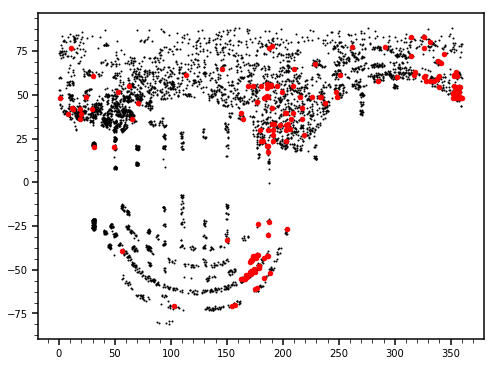

In [27]:

In = np.genfromtxt('processed/BHBs_cartesian_heliocentric.txt',skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

#tl,tb,td,tvr,tdml,tdmb = jorge_galactic(x,y,z,vx,vy,vz)


l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

sgrweak = In[:,16]
sgrstrong = In[:,17]

feh = In[:,18]

print(feh)

plt.scatter(l,b,color='black',s=1.)
plt.scatter(l[sgrstrong==1],b[sgrstrong==1],color='red',s=20.)

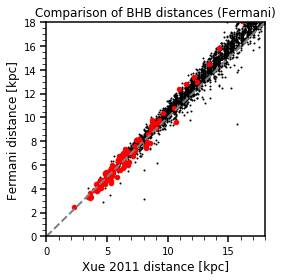

In [17]:
Gmag = fs_mag(X11['gr'],gaiadict['sfehspec'])

fibredist = 10.**((gaiadict['sfibreg']-Gmag+5.)/5.-3.)
#plt.scatter(X11['gmag'],10.**((X11['gmag']-Gmag+5.)/5.-3.),s=2.,color='black')

#plt.scatter(X11['d'],10.**((X11['gmag']-Gmag+5.)/5.-3.),s=2.,color='black')





plt.figure(figsize=(4,4))

#plt.scatter(X11['gmag'],gaiadict['gphot_g_mean_mag'],color='black',s=1.)

plt.scatter(X11['d'],10.**((X11['gmag']-Gmag+5.)/5.-3.),s=1.,color='black')


w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5.)[0]
#plt.scatter(X11['d'][w],1./gaiadict['gparallax'][w],s=20.,color='red')
#plt.scatter(X11['gmag'][w],gaiadict['gphot_g_mean_mag'][w],color='red',s=20.)
plt.scatter(X11['d'][w],10.**((X11['gmag'][w]-Gmag[w]+5.)/5.-3.),s=20.,color='red')




plt.plot([0.,30.],[0.,30.],color='gray',linestyle='dashed')

plt.ylim(0,18)
plt.xlim(0,18)
plt.xlabel('Xue 2011 distance [kpc]',size=12)
plt.ylabel('Fermani distance [kpc]',size=12)
plt.title('Comparison of BHB distances (Fermani)',size=12)

plt.tight_layout()
plt.savefig('/Users/mpetersen/Dropbox/mike/Models_30March/bhb_distances_fermani.png')





# d = 10^((m-M+5)/5)


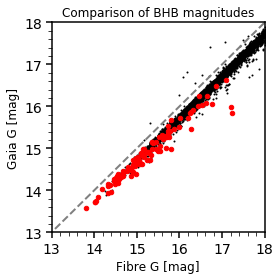

In [302]:


plt.figure(figsize=(4,4))

#plt.scatter(X11['gmag'],gaiadict['gphot_g_mean_mag'],color='black',s=1.)
plt.scatter(gaiadict['sfibreg'],gaiadict['gphot_g_mean_mag'],color='black',s=1.)



w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5.)[0]
#plt.scatter(X11['d'][w],1./gaiadict['gparallax'][w],s=20.,color='red')
#plt.scatter(X11['gmag'][w],gaiadict['gphot_g_mean_mag'][w],color='red',s=20.)
plt.scatter(gaiadict['sfibreg'][w],gaiadict['gphot_g_mean_mag'][w],color='red',s=20.)




plt.plot([0.,30.],[0.,30.],color='gray',linestyle='dashed')

plt.ylim(13,18)
plt.xlim(13.,18)
#plt.xlabel('Xue 2011 G [mag]',size=12)
plt.xlabel('Fibre G [mag]',size=12)
plt.ylabel('Gaia G [mag]',size=12)
plt.title('Comparison of BHB magnitudes',size=12)

plt.tight_layout()
plt.savefig('/Users/mpetersen/Dropbox/mike/Models_30March/bhb_magnitudes_fibre.png')



[ 0.01349299 -0.05644677]


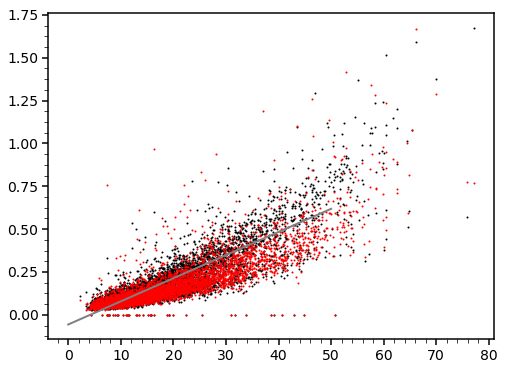

In [234]:
# estimate the error as a function of distance


plt.scatter(X11['d'],gaiadict['gpmra_error'],color='black',s=1.)
plt.scatter(X11['d'],gaiadict['gpmdec_error'],color='red',s=1.)


p = np.polyfit(X11['d'][np.isfinite(gaiadict['gpmra_error'])],gaiadict['gpmra_error'][np.isfinite(gaiadict['gpmra_error'])],1)
print(p)
pfunc = np.poly1d(p)

dcheck = np.linspace(0.,50.,100)
plt.plot(dcheck,pfunc(dcheck),color='gray')




#plt.ylim(0.,10.)


[ 0.20939577 -0.04890582]


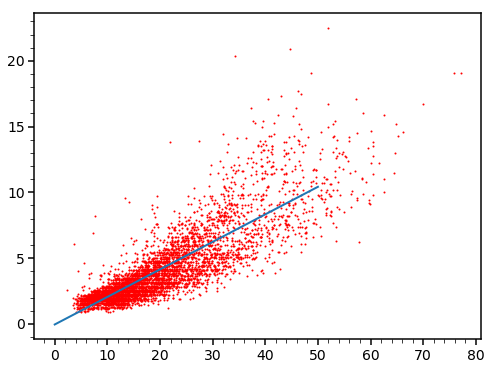

In [226]:
plt.scatter(X11['d'],X11['eHRV'],color='red',s=1.)

p = np.polyfit(X11['d'],X11['eHRV'],1)
print(p)
pfunc = np.poly1d(p)

dcheck = np.linspace(0.,50.,100)
plt.plot(dcheck,pfunc(dcheck))


In [104]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html


def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq."""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)]).T

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    return np.array([-np.sin(a),np.cos(a),0.]).T

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),0.]).T

def return_rgal(l,b):
    """ eq."""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)]).T

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    return np.array([-np.sin(l),np.cos(l),0.]).T

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),0.]).T





def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    #rgal = return_rgal(ell,b)
    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)

    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)

    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

#print(G)


a = 45.*np.pi/180.
d = 45.*np.pi/180.


cov_to = rotate_errors(a,d,1,2.,-0.25)
print(cov_to)


#print(ricrs,rgal,ell,b)

[[1.21186271 0.13875855]
 [0.13875855 0.0301345 ]]


In [108]:
i = 4
print(gaiadict['gra'][bigd][i]*np.pi/180.,gaiadict['gdec'][bigd][i]*np.pi/180.,\
                       gaiadict['gpmra_error'][bigd][i],gaiadict['gpmdec_error'][bigd][i],gaiadict['gpmcorr'][bigd][i])

e1 = gaiadict['gpmra_error'][bigd][i]
e2 = gaiadict['gpmdec_error'][bigd][i]
e3 = gaiadict['gpmcorr'][bigd][i]
cov_to = rotate_errors(gaiadict['gra'][bigd][i]*np.pi/180.,gaiadict['gdec'][bigd][i]*np.pi/180.,\
                       e1,e2,e3)


old_angle = 0.5*np.arctan2(2*e3,e2-e1)
rot_angle = 0.5*np.arctan2(2*cov_to[0][1],cov_to[1][1]-cov_to[0][0])
print(old_angle,rot_angle)

4.391132116629219 0.7149783917465259 0.4993436163332067 0.504498316505463 0.26259503
0.7804908593066905 0.8875696843970196


In [ ]:
c = coord.SkyCoord(ra=gaiadict['gra'][bigd]*u.deg,\
                   dec=gaiadict['gdec'][bigd]*u.deg,\
                   pm_ra_cosdec=gaiadict['gpmra'][bigd]*u.mas/u.yr,\
                   pm_dec=gaiadict['gpmdec'][bigd]*u.mas/u.yr)


plt.scatter(np.array(c.galactic.l),np.array(c.galactic.b),color=cm.coolwarm((gaiadict['gpmcorr'][bigd]+0.5),1.),s=50.)

In [67]:
return_gaia_Agprime()

array([[-0.05487556, -0.87343709, -0.48383502],
       [ 0.49410943, -0.44482963,  0.74698224],
       [-0.86766615, -0.19807637,  0.45598378]])

In [61]:
c.isscalar

False

In [23]:


# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)


class dataset(object):
    '''placeholder for all the quantities we want
    '''
    ra = None
    dec = None
    l = None
    b = None
    d = None
    x = None
    y = None
    z = None
    vx = None
    vy = None
    vz = None
    r = None
    th = None
    ph = None
    vr = None
    vth = None
    vph = None
    pmra = None
    pmdec = None
    epmra = None
    epmdec = None
    vrad = None
    evrad = None
    feh = None
    gflux = None

    
class newcoordinates():
    """take a system with
    
    ra,dec,ra_error,dec_error,pmra,pmdec,pmra_error,pmdec_error,dist,dist_error
    
    """
    
    def __init__(self,inputcatalog,errors=False):
        """take input catalog and make homogenous system
        
        how do we treat missing data in this framework?
        
        """
        
        self.ra       = inputcatalog['ra']
        self.dec      = inputcatalog['dec']
        self.d        = inputcatalog['d']
        self.pmra     = inputcatalog['pmra']
        self.pmdec    = inputcatalog['pmdec']
        self.vrad     = inputcatalog['vrad']

    
        if errors:
            self.raerr    = inputcatalog['raerr']
            self.decerr   = inputcatalog['decerr']
            self.derr     = inputcatalog['derr']        
            self.pmraerr  = inputcatalog['pmraerr']        
            self.pmdecerr = inputcatalog['pmdecerr']        
            self.vraderr  = inputcatalog['vraderr']
        
        
    def find_covariances(self):
        """look at the errors and find real estimates for errors based on the covariances
        
        -should we brute force the errors as a monte carlo?
        
        """
        
        cplus = coord.SkyCoord(ra  = self.ra    + self.raerr    * u.deg,\
                   dec             = self.dec   + self.decerr   * u.deg,\
                   distance        = self.d     + self.derr     * u.kpc,\
                   pm_ra_cosdec    = self.pmra  + self.pmraerr  * u.mas/u.yr,\
                   pm_dec          = self.pmdec + self.pmdecerr * u.mas/u.yr,\
                   radial_velocity = self.vrad  + self.vraderr  * u.km/u.s)
        


    def gc_transform(self):
        '''define a galactic transform
        
        '''
        
        c = coord.SkyCoord(ra      = self.ra    * u.deg,\
                   dec             = self.dec   * u.deg,\
                   distance        = self.d     * u.kpc,\
                   pm_ra_cosdec    = self.pmra  * u.mas/u.yr,\
                   pm_dec          = self.pmdec * u.mas/u.yr,\
                   radial_velocity = self.vrad  * u.km/u.s)
        

        gal_defined = c.transform_to(gc_frame)
        gal_latlon  = c.transform_to('galactic')
        sgr = c.transform_to(Sagittarius)
        
        self.sLambda = sgr.Lambda
        self.sBeta   = sgr.Beta
        
        self.x = gal_defined.x
        self.y = gal_defined.y
        self.z = gal_defined.z
        
        self.vx = gal_defined.v_x
        self.vy = gal_defined.v_y
        self.vz = gal_defined.v_z

        # do a transform of l to the correct orientation?
        tmpl = gal_latlon.l
        
        self.l = np.array(tmpl)

        #self.l[self.l>180.] -= 360.
        #self.l *= -1.
        
        
        
        self.b = np.array(gal_latlon.b)
        
        # be careful about the cos(b) term included here...
        self.vl     = np.array(gal_latlon.pm_l_cosb)
        self.vb     = np.array(gal_latlon.pm_b)
        
        self.gdist  = np.array(gal_latlon.distance)
        self.gsr    = np.array(gal_latlon.radial_velocity)

    def sph_transform(self):
        """convert cartesian to spherical
        """
        self.rho    = np.sqrt(self.x*self.x + self.y*self.y + self.z*self.z)
        self.r      = np.sqrt(self.x*self.x + self.y*self.y)
        self.phi    = np.arctan2(self.y,self.x)
        self.theta  = np.arccos(self.z/self.r)

        self.vr     = (self.x*self.vx + self.y*self.vy + self.z*self.vz)/self.rho
        self.vphi   = (self.vx*self.y - self.x*self.vy)/(self.r*self.r)
        self.vtheta = ( self.z*(self.x*self.vx + self.y*self.vy) \
                     - self.r*self.r*self.vz )/(self.rho*self.rho*self.r)   
        
        
    

    

In [25]:
dist,b,l,vlos,vtheta,vphi = rm.compute_spherical(xpos,ypos,zpos,xvel,yvel,zvel)



AttributeError: module 'reflexmotion' has no attribute 'compute_spherical'

In [27]:
indx = 1000
ra = X11['RA'][keep[indx]]
dec = X11['Dec'][keep[indx]]
d = X11['d'][keep[indx]]
derr = np.array(0.05*X11['d'][keep[indx]]) # fixed 5% error
pmra = gaiadict['gpmra'][keep[indx]]
pmraerr = gaiadict['gpmra_error'][keep[indx]]
pmdec = gaiadict['gpmdec'][keep[indx]]
pmdecerr = gaiadict['gpmdec_error'][keep[indx]]
vrad = gaiadict['selodiervfinal'][keep[indx]]
vraderr = gaiadict['selodiervfinalerr'][keep[indx]]

#print(ra,dec,d,pmra,)

nsamples = 10000

cplus = coord.SkyCoord(ra              = np.tile(ra,nsamples)                                 * u.deg,\
                       dec             = np.tile(dec,nsamples)                                 * u.deg,\
                       distance        = (d     + np.random.normal(size=nsamples)*derr)     * u.kpc,\
                       pm_ra_cosdec    = (pmra  + np.random.normal(size=nsamples)*pmraerr)  * u.mas/u.yr,\
                       pm_dec          = (pmdec + np.random.normal(size=nsamples)*pmdecerr) * u.mas/u.yr,\
                       radial_velocity = (vrad  + np.random.normal(size=nsamples)*vraderr)  * u.km/u.s)


gal_latlon  = cplus.transform_to('galactic')
gal_defined = cplus.transform_to(gc_frame)



IndexError: tuple index out of range

58.43902077752686 64.67862242770383 70.93786711631695
-196.1418688571588 -166.56196177944733 -136.17893436810564


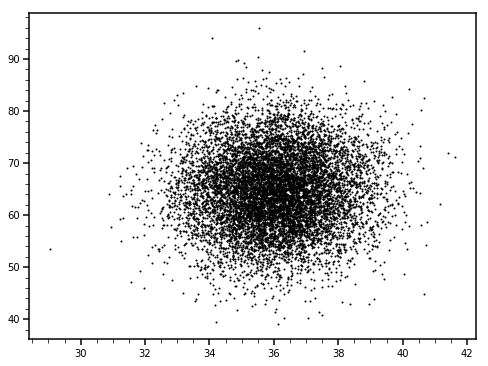

In [22]:
#plt.scatter(gal_latlon.pm_l_cosb,gal_latlon.pm_b,color='black',s=1.)

dist,b,l,vlos,vtheta,vphi = rm.compute_spherical(np.array(gal_defined.x),np.array(gal_defined.y),np.array(gal_defined.z),\
                                                np.array(gal_defined.v_x),np.array(gal_defined.v_y),np.array(gal_defined.v_z))



#plt.scatter(gal_defined.x,gal_defined.v_x,color='black',s=1.)
#plt.scatter(gal_defined.y,gal_defined.v_y,color='red',s=1.)
#plt.scatter(gal_defined.z,gal_defined.v_z,color='blue',s=1.)

#plt.scatter(180.*l/np.pi,180.*b/np.pi,color='black',s=1.)
#plt.axis([0,360,-90,90])

plt.scatter(dist,vlos,color='black',s=1.)

print(np.percentile(vlos,20.),np.percentile(vlos,50.),np.percentile(vlos,80.))
print(np.percentile(vphi,20.),np.percentile(vphi,50.),np.percentile(vphi,80.))




### Really need to flag GCs. You have the list, just do it already!

In [36]:
bhbcat = {}
bhbcat['ra'] = X11['RA'][keep]
bhbcat['dec'] = X11['Dec'][keep]
bhbcat['d'] = X11['d'][keep]
bhbcat['pmra'] = gaiadict['gpmra'][keep]#*np.cos(X11['Dec'][keep]* np.pi / 180.)
bhbcat['pmdec'] = gaiadict['gpmdec'][keep]
bhbcat['vrad'] = gaiadict['selodiervfinal'][keep]
bhbcat['feh'] = gaiadict['sfehspec'][keep]


In [37]:
BHB = newcoordinates(bhbcat)

BHB.gc_transform()
BHB.sph_transform()

In [38]:
BHB.x

<Quantity [  6.48672475,  -2.14758993,  -2.06893261, ...,  -3.55010681,
            -2.59577804, -21.26056491] kpc>

In [25]:
# print to a file...

# with a flipped vb ONLY?


def jorge_galactic(x0,y0,z0,u0,v0,w0):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    
    # following the astropy conversion
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    #dL=np.arctan(y0/x0)/f
    
    #dL[(y0<0)&(x0>0.)] += 360.
    #dL[(y0>0)&(x0<0.)] += 180.
    #dL[(y0<0)&(x0<0.)] += 180.
    
    dL = np.arctan2(y0,x0)/f
    
    #print(dL)
    
    if dL.size>1:
        dL[np.array(dL)<0.] += 360.
    else:
        if dL<0.: dL+=360.
    #if ((y0<0)&(x0>0.)): dL=dL+360.
    #if ((y0>0)&(x0<0.)): dL=dL+180.
    #if ((y0<0)&(x0<0.)): dL=dL+180.
    
    return dL,dB,rad,vr,dmul,dmub


#dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(KGiant.x),np.array(KGiant.y),np.array(KGiant.z),\
#                               np.array(KGiant.vx),np.array(KGiant.vy),np.array(KGiant.vz))












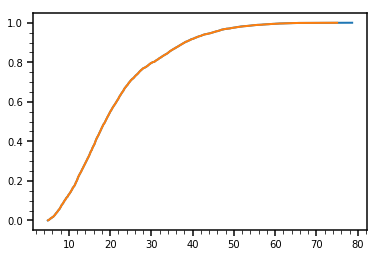

In [38]:
# interpolate the distance function to select mock stars

distsort = np.argsort(radj)
plt.plot(radj[distsort],np.linspace(0.,1.,radj.size))

f=open('bhbgiantrange.txt','w')
for indx in range(radj.size): print(radj[distsort][indx],np.linspace(0.,1.,radj.size)[indx],file=f)
f.close()
    
    
# invert to interpolate
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

spl = UnivariateSpline(radj[distsort],np.linspace(0.,1.,radj.size),k=4,s=1)
spl = interp1d(radj[distsort],np.linspace(0.,1.,radj.size),'nearest')
tstdist = np.linspace(5.,75.,1000)
plt.plot(tstdist,spl(tstdist))



In [170]:
BHB['feh']

TypeError: 'newcoordinates' object is not subscriptable

In [130]:
X11['Dec']

array([6.29243, 6.42941, 7.10858, ..., 0.63088, 0.36596, 0.47167])

In [163]:
# test the definitions of vl and vb

#17 45 40.04 -29 00 28.1
testcat = {}
testcat['ra'] = np.array([15.*(17.+(45./60.)+40.04/3600.)])
testcat['dec'] = np.array([-(29.+(0.)+28.1/3600.)])
testcat['d'] = np.array([8.2])
testcat['pmra'] = np.array([-0.2])
testcat['pmdec'] = np.array([0.2])
testcat['vrad'] = np.array([0.1])

T = newcoordinates(testcat)

T.gc_transform()
T.sph_transform()

print(T.l,T.b,T.vl,T.vb)

# takeaways: positive pmra, when facing the galactic centre, means increasing vl
# takeaways: positive pmdec, when facing the galactic centre, means increasing vb

[-0.05574013] [-0d02m46.1846s] [0.06652945] mas / yr [0.27490695] mas / yr


In [147]:
np.nanmin(X11['Dec'])

-19.25249

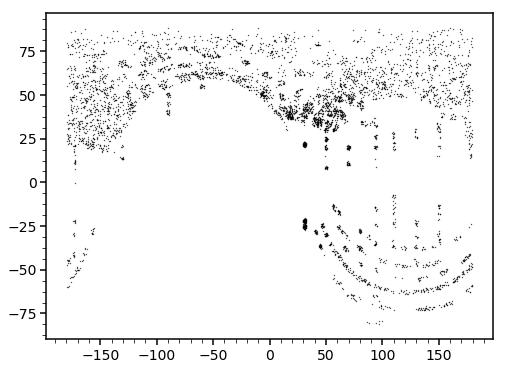

In [13]:
plt.scatter(BHB.l,BHB.b,color='black',s=0.1)

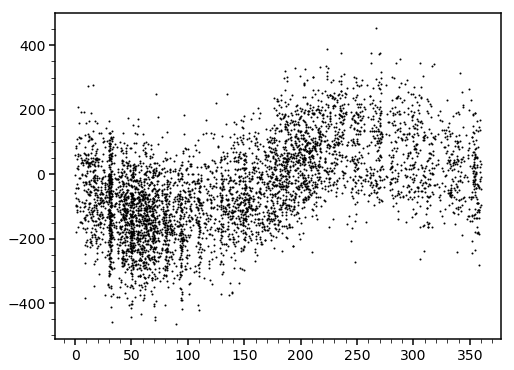

In [14]:
# try to transform back...

repv = coord.CartesianDifferential(d_x=BHB.vx,d_y=BHB.vy,d_z=BHB.vz)
rep = coord.CartesianRepresentation(x=BHB.x,y=BHB.y,z=BHB.z,\
                                    differentials=repv,unit='kpc')




#rep = coord.SkyCoord(x=BHB.x,y=BHB.y,z=BHB.z,unit='kpc',\
#                     representation_type='cartesian')


rept = coord.Galactocentric(rep)
repgal = rept.transform_to(coord.Galactic)

plt.scatter(repgal.l.degree,repgal.radial_velocity.value,color='black',s=1.)


#repgal = rept.transform_to(coord.Heliocentric)


#plt.scatter(repgal.l.degree,repgal.pm_l_cosb.value,color='black',s=1.)



In [15]:
Gmatch['ra']

array([331.04739862, 330.60694414, 330.92495452, ..., 191.67356168,
       191.2056253 , 147.16766211])

(0.0, 1.0)

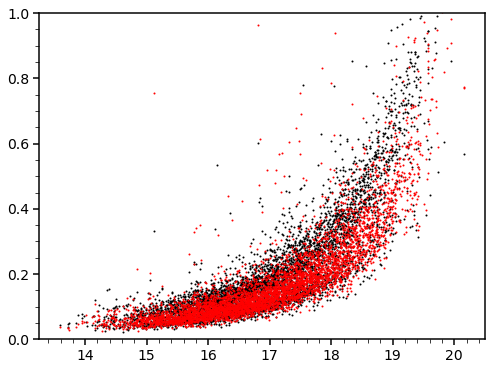

In [16]:
plt.scatter(Gmatch['phot_g_mean_mag'],Gmatch['pmra_error'],color='black',s=1.)
plt.scatter(Gmatch['phot_g_mean_mag'],Gmatch['pmdec_error'],color='red',s=1.)


#plt.axis([-1,1.,-1,1.])
plt.ylim([0.,1.])

[-3.5, 1.0, -3.5, 1.0]

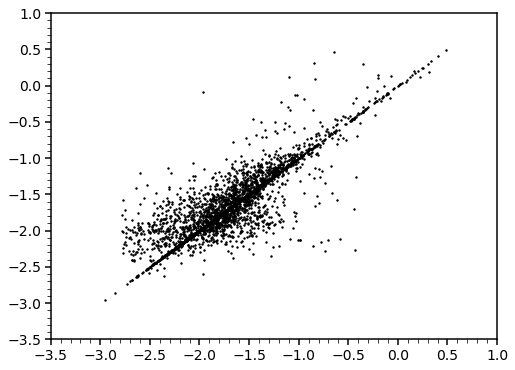

In [17]:
plt.scatter(X11m['fehadop'],X11m['fehspec'],color='black',s=2.)
plt.axis([-3.5,1.,-3.5,1.])

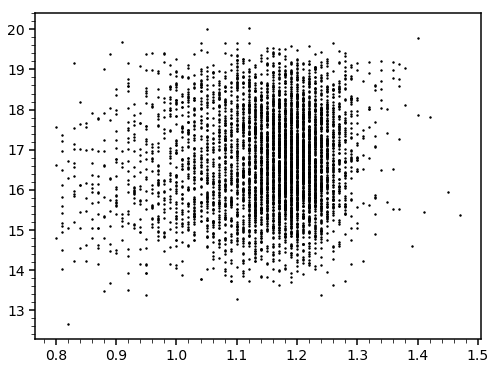

In [18]:
# verifications. 

plt.scatter(X11['ug'],X11['gmag'],color='black',s=2.)

In [19]:
# some duplicates from the Gaia crossmatch. thrown out for now, could circle back to them.

uu, c = np.unique(Gmatch['xsource_id'], return_counts=True)
print(uu[c > 1])

[b'S1368' b'S1417' b'S2721' b'S2974' b'S3728']


In [201]:
# now use the the color and metallicity dependent 
# absolute magnitude relation derived by Fermani & Schönrich (2013)

def fs_mag(gr,feh):
    """use equation 5 of fermani & schonrich 2013 to get the absolute G magnitude
    """
    
    if feh < -5.:
        return np.nan
    else:
        return 0.0075 * np.exp(-14.*gr) + 0.04 * (feh + 3.5)**2. + 0.25
    
    
    

(-0.0001, 0.0001)

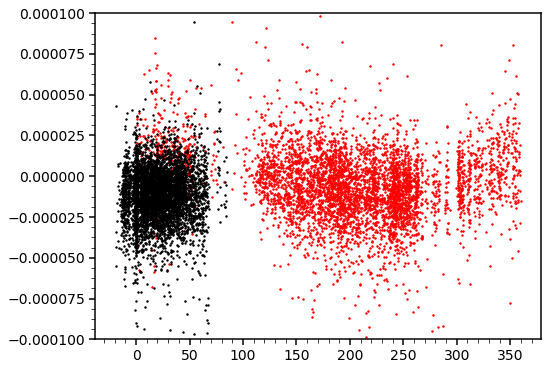

In [21]:
#plt.scatter(X11['gmag'],psfg - X11['gmag'],color='black',s=2.)
plt.scatter(X11['RA'],gaiadict['gra'] -X11['RA'],color='red',s=2.)
plt.scatter(X11['Dec'],gaiadict['gdec'] -X11['Dec'],color='black',s=2.)


plt.ylim(-0.0001,0.0001)

In [22]:
# need to double check all this matching...something doesn't seem right.
decoded_names = np.array([int((X11m['Name'][x].decode()).strip('S')) for x in range(0,X11m['Name'].size)])

# do the cross-matching to the original Xue sample
# everything is therefore matched to the X11 sample


grvals = X11["gr"]
fehvals = np.zeros(grvals.size) + np.nan
absg = np.zeros(grvals.size)
radval = np.zeros(grvals.size)
gaiag = np.zeros(grvals.size)
gaiacolor = np.zeros(grvals.size)
pmr = np.zeros(grvals.size)
pmd = np.zeros(grvals.size)
psfg = np.zeros(grvals.size)
fibreg = np.zeros(grvals.size)
raval = np.zeros(grvals.size)
decval = np.zeros(grvals.size)

gaiadict = {}

matchlist = ["gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","dist"]

for match in matchlist:
    gaiadict['g'+match] = np.zeros(grvals.size)
    

sdss_list = ["specobjid","ra","dec",\
                                         "plate","mjd","fiberid","fehadop",\
                                        "fehadopunc","elodiervfinal","elodiervfinalerr",\
                                         "fehspec","fehspecunc","psfg","fibreg"]

for match in sdss_list:
    gaiadict['s'+match] = np.zeros(grvals.size)
    


for indx,val in enumerate(decoded_names):
    # for verification
    #print(val,X11m['Name'][indx],\
    #      X11m['ra'][indx]-Gmatch['ra'][Gmatch['xsource_id']==X11m['Name'][indx]][0],\
    #     X11m['dec'][indx]-Gmatch['dec'][Gmatch['xsource_id']==X11m['Name'][indx]][0])
    fehvals[val] = X11m['fehadop'][indx]
    #fehvals[val] = X11m['fehspec'][indx]
    psfg[val] = X11m['psfg'][indx]
    fibreg[val] = X11m['fibreg'][indx]
    absg[val] = fs_mag(grvals[val],fehvals[val])
    radval[val] = X11m['elodiervfinal'][indx]
    raval[val] = X11m['ra'][indx]
    decval[val] = X11m['dec'][indx]
    
    for match in sdss_list:
        gaiadict['s'+match][val] = X11m[match][indx]
    




    #radval[val] = X11[''][indx]
    
    try:
        for match in matchlist:
            #print(gaiadict[match][val])
            #print(Gmatch[match][Gmatch['xsource_id']==X11m['Name'][indx]])
            gaiadict['g'+match][val] = Gmatch[match][Gmatch['xsource_id']==X11m['Name'][indx]]
    except:
        print('Failure')
    
    try:
        gaiag[val] = Gmatch['phot_g_mean_mag'][Gmatch['xsource_id']==X11m['Name'][indx]]
        gaiacolor[val] = Gmatch['bp_rp'][Gmatch['xsource_id']==X11m['Name'][indx]]
        pmr[val] = Gmatch['pmra'][Gmatch['xsource_id']==X11m['Name'][indx]]
        pmd[val] = Gmatch['pmdec'][Gmatch['xsource_id']==X11m['Name'][indx]]
    except:
        #print('Failure')
        gaiag[val] = np.nan
        gaiacolor[val] = np.nan
        pmr[val] = np.nan
        pmd[val] = np.nan
        
        
radval = X11['HRV']

Failure
Failure
Failure
Failure
Failure
Failure


(-0.0001, 0.0001)

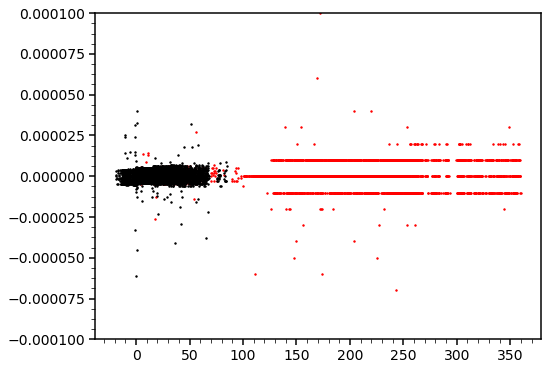

In [23]:
#plt.scatter(X11['gmag'],psfg - X11['gmag'],color='black',s=2.)
plt.scatter(X11['RA'],raval -X11['RA'],color='red',s=2.)
plt.scatter(X11['Dec'],decval -X11['Dec'],color='black',s=2.)


plt.ylim(-0.0001,0.0001)

(0.0, 3.0)

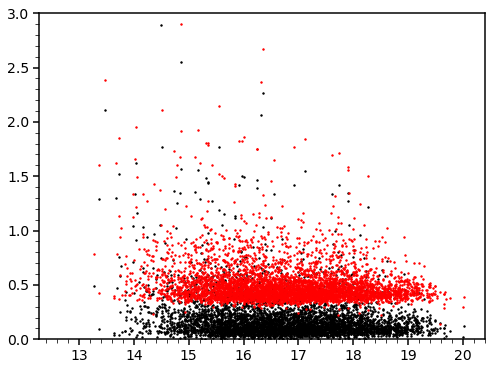

In [24]:
plt.scatter(X11['gmag'],psfg - X11['gmag'],color='black',s=2.)
plt.scatter(X11['gmag'],fibreg -X11['gmag'],color='red',s=2.)
plt.ylim(0.,3.)

1251
1155


(-5.0, 1.0)

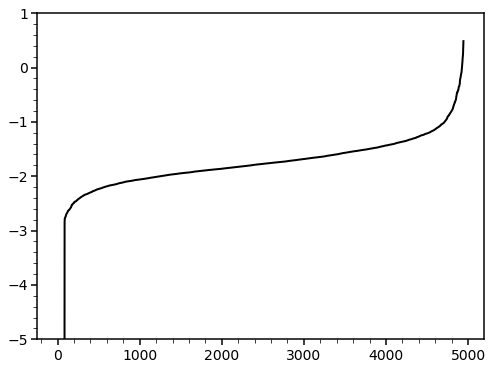

In [25]:
#plt.scatter(X11m['fehadop'],X11m['fehspec'],color='black',s=2.)
#plt.axis([-5.,1.,-5.,1.])

print(len(np.where(fehvals[keep]<-2.0)[0]))
print(len(np.where(fehvals[keep]>-1.5)[0]))


plt.plot(fehvals[keep][fehvals[keep].argsort()],color='black')
plt.ylim(-5.,1.)

Text(0, 0.5, 'Gaia G')

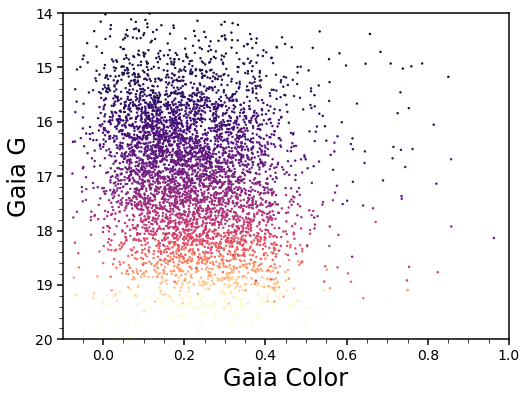

In [164]:
plt.scatter(gaiacolor[keep],gaiag[keep],color=cm.magma(X11['d'][keep]/50.,1.),s=2.)
plt.axis([-0.1,1.,20.,14.])
plt.xlabel('Gaia Color')
plt.ylabel('Gaia G')
# this doesn't really make any sense.

# biggest source of cutting down sources is g<17 selection in SDSS.

# perhaps do better by cutting on some noise tolerance in Gaia?

In [27]:
# set the coordinates
usun = 11.1
vsun = 12.24
wsun = 7.25
vcirc = 235.
rsun = 8.3 # in kpc
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)

In [28]:
# set up coordinates and transform to the frame we want

c = coord.SkyCoord(ra=X11['RA'][keep]*u.deg,\
                   dec=X11['Dec'][keep]*u.deg,\
                   distance=X11['d'][keep]*u.kpc,\
                   pm_ra_cosdec=pmr[keep]*u.mas/u.yr,\
                   pm_dec=pmd[keep]*u.mas/u.yr,\
                   radial_velocity=radval[keep]*u.km/u.s)


#gc1 = c.transform_to(coord.Galactocentric) # this is default galactic
gc1 = c.transform_to(gc_frame) # for specific coordinates set above
#print(gc1.x,gc1.v_x, gc1.v_y, gc1.v_z)

In [29]:
def spherical_velocities(x,y,z,vx,vy,vz):
    """convert cartesian to spherical
    """
    rho = np.sqrt(x*x + y*y + z*z)
    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    
    vr = (x*vx + y*vy + z*vz)/rho
    vtheta = (vx*y - x*vy)/(r*r)
    vphi = ( z*(x*vx + y*vy) - r*r*vz )/(rho*rho*r)
    
    return r,theta,phi,vr,vtheta,vphi

r,theta,phi,vr,vtheta,vphi = spherical_velocities(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

In [30]:
# also need one for viewing velocities?
# we already have this measured...

# can astropy go backwards?



In [31]:
print(np.nanmedian(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y + gc1.z*gc1.z)))

18.82515496811176 kpc


In [32]:
(gaiag[keep]-14)/6.

array([0.86060783, 0.53378   , 0.55694333, ..., 0.54131133, 0.6434625 ,
       0.711141  ])

(-400.0, 400.0)

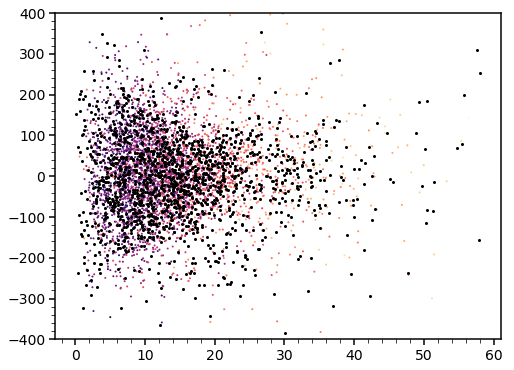

In [165]:


plt.scatter(r[nonsgrstars],gc1.v_z[nonsgrstars],\
            color=cm.magma((gaiag[keep][nonsgrstars]-14.)/6.,1.),s=1.)

plt.scatter(r[sgrstars],gc1.v_z[sgrstars],\
            color='black',s=4.)



plt.ylim(-400.,400.)


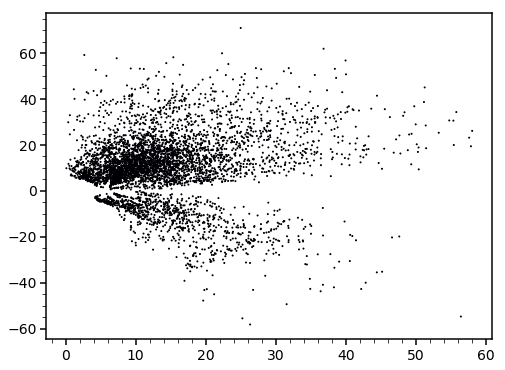

In [34]:
# plot the transformed velocities of the kept stars
plt.scatter(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y),gc1.z,color=cm.magma((np.array(gc1.v_z)+np.nanmin(np.array(gc1.v_z)))/(2.*np.nanmax(np.array(gc1.v_z))),1.),s=1.)
#plt.scatter(gc1.x,gc1.y,color='black',s=1.)

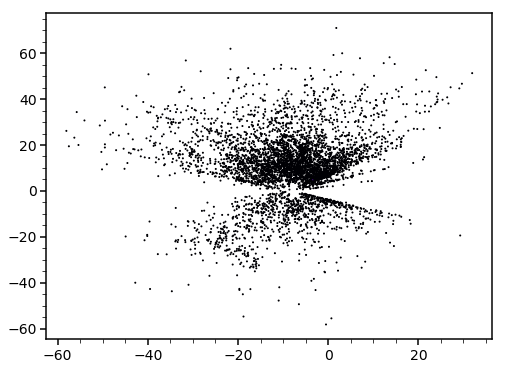

In [35]:
plt.scatter(gc1.x,gc1.z,color=cm.magma((np.array(gc1.v_z)+np.nanmin(np.array(gc1.v_z)))/(2.*np.nanmax(np.array(gc1.v_z))),1.),s=1.)



In [36]:
# set up coordinates and transform to the frame we want

c = coord.SkyCoord(ra=X11['RA'][keep][nonsgrstars]*u.deg,\
                   dec=X11['Dec'][keep][nonsgrstars]*u.deg,\
                   distance=X11['d'][keep][nonsgrstars]*u.kpc,\
                   pm_ra_cosdec=pmr[keep][nonsgrstars]*u.mas/u.yr,\
                   pm_dec=pmd[keep][nonsgrstars]*u.mas/u.yr,\
                   radial_velocity=radval[keep][nonsgrstars]*u.km/u.s)


#gc1 = c.transform_to(coord.Galactocentric) # this is default galactic
gc1 = c.transform_to(gc_frame) # for specific coordinates set above
#print(gc1.x,gc1.v_x, gc1.v_y, gc1.v_z)

NameError: name 'nonsgrstars' is not defined

In [37]:
def spherical_velocities(x,y,z,vx,vy,vz):
    """convert cartesian to spherical
    """
    rho = np.sqrt(x*x + y*y + z*z)
    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    
    vr = (x*vx + y*vy + z*vz)/rho
    vtheta = (vx*y - x*vy)/(r*r)
    vphi = ( z*(x*vx + y*vy) - r*r*vz )/(rho*rho*r)
    
    return r,theta,phi,vr,vtheta,vphi

r,theta,phi,vr,vtheta,vphi = spherical_velocities(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

In [38]:
binsample = 400
gdist = np.array(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y + gc1.z*gc1.z))
ogdist = gdist.argsort()

binvals = int(np.floor(gdist.size))
binlist = np.zeros(binvals)
vrarr = np.zeros(binvals)
vzarr = np.zeros(binvals)
vphiarr = np.zeros(binvals)
vthetaarr = np.zeros(binvals)
vrarr2 = np.zeros(binvals)
vzarr2 = np.zeros(binvals)
vphiarr2 = np.zeros(binvals)
vthetaarr2 = np.zeros(binvals)


for ib,b in enumerate(range(binvals)):
    if ib!=(binvals-1):
        #print(gdist[ogdist[ib*binsample:(ib+1)*binsample]])
        binlist[ib] = np.nanmean(gdist[ogdist[ib*binsample:(ib+1)*binsample]])
        vrarr[ib] = np.nanmean(np.array(vr)[ogdist[ib*binsample:(ib+1)*binsample]])
        vphiarr[ib] = np.nanmean(np.array(vphi)[ogdist[ib*binsample:(ib+1)*binsample]])
        vthetaarr[ib] = np.nanmean(np.array(vtheta)[ogdist[ib*binsample:(ib+1)*binsample]])
        vzarr[ib] = np.nanmean(np.array(gc1.v_z)[ogdist[ib*binsample:(ib+1)*binsample]])
        vrarr2[ib] = np.nanmean(np.array(vr*vr)[ogdist[ib*binsample:(ib+1)*binsample]])
        vphiarr2[ib] = np.nanmean(np.array(vphi*vphi)[ogdist[ib*binsample:(ib+1)*binsample]])
        vthetaarr2[ib] = np.nanmean(np.array(vtheta*vtheta)[ogdist[ib*binsample:(ib+1)*binsample]])
        vzarr2[ib] = np.nanmean(np.array(gc1.v_z*gc1.v_z)[ogdist[ib*binsample:(ib+1)*binsample]])
    else:
        binlist[ib] = np.nanmean(gdist[ogdist[ib*binsample:]])
        vrarr[ib] = np.nanmean(np.array(vr)[ogdist[ib*binsample:]])
        vphiarr[ib] = np.nanmean(np.array(vphi)[ogdist[ib*binsample:]])
        vthetaarr[ib] = np.nanmean(np.array(vtheta)[ogdist[ib*binsample:]])
        vzarr[ib] = np.nanmean(np.array(gc1.v_z)[ogdist[ib*binsample:]])
        vrarr2[ib] = np.nanmean(np.array(vr*vr)[ogdist[ib*binsample:]])
        vphiarr2[ib] = np.nanmean(np.array(vphi*vphi)[ogdist[ib*binsample:]])
        vthetaarr2[ib] = np.nanmean(np.array(vtheta*vtheta)[ogdist[ib*binsample:]])
        vzarr2[ib] = np.nanmean(np.array(gc1.v_z*gc1.v_z)[ogdist[ib*binsample:]])


    

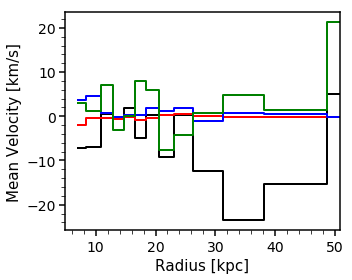

In [39]:
plt.figure(figsize=(5,4))

plt.plot(binlist,vrarr,color='black',drawstyle='steps-mid')
plt.plot(binlist,vphiarr,color='red',drawstyle='steps-mid')
plt.plot(binlist,vthetaarr,color='blue',drawstyle='steps-mid')
plt.plot(binlist,vzarr,color='green',drawstyle='steps-mid')


plt.xlabel('Radius [kpc]',size=15)
plt.ylabel('Mean Velocity [km/s]',size=15)
plt.tight_layout()


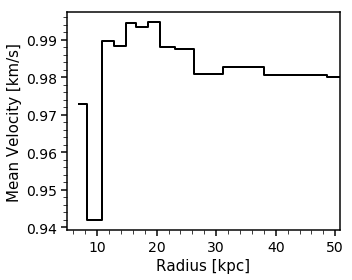

In [40]:
plt.figure(figsize=(5,4))

betaarr = 1. - 0.5*(vphiarr2+vthetaarr2)/(vrarr2)

plt.plot(binlist,betaarr,color='black',drawstyle='steps-mid')
#plt.plot(binlist,vphiarr,color='red',drawstyle='steps-mid')
#plt.plot(binlist,vthetaarr,color='blue',drawstyle='steps-mid')
#plt.plot(binlist,vzarr,color='green',drawstyle='steps-mid')


plt.xlabel('Radius [kpc]',size=15)
plt.ylabel('Mean Velocity [km/s]',size=15)
plt.tight_layout()



In [16]:

#http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_sgr-coordinate-frame.html

from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u

class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        http://adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        http://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }
    
    

SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree


# Generate the rotation matrix using the x-convention (see Goldstein)
D = rotation_matrix(SGR_PHI, "z")
C = rotation_matrix(SGR_THETA, "x")
B = rotation_matrix(SGR_PSI, "z")
A = np.diag([1.,1.,-1.])
SGR_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)





In [42]:
sgr = c.transform_to(Sagittarius) # for specific coordinates set above



In [93]:
sgr.Beta.size

4944

1547


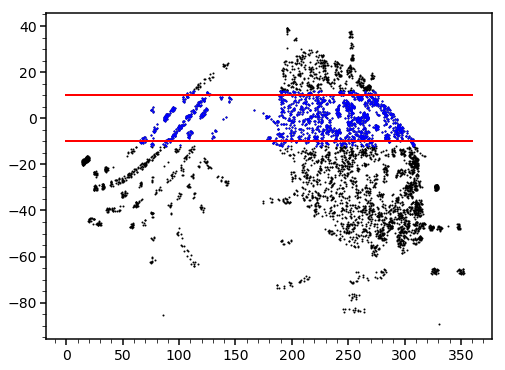

In [43]:
sgr = c.transform_to(Sagittarius) # for specific coordinates set above

plt.scatter(sgr.Lambda,sgr.Beta,color='black',s=1.)
plt.plot([0.,360.],[10.,10.],color='red')
plt.plot([0.,360.],[-10.,-10.],color='red')

sgrstars = np.where( (np.abs(np.array(sgr.Beta))<12.))[0]
nonsgrstars = np.where( (np.abs(np.array(sgr.Beta))>12.))[0]


print(sgrstars.size)


plt.scatter(sgr.Lambda[sgrstars],sgr.Beta[sgrstars],color='blue',s=1.)




In [44]:
# find distances? in bins

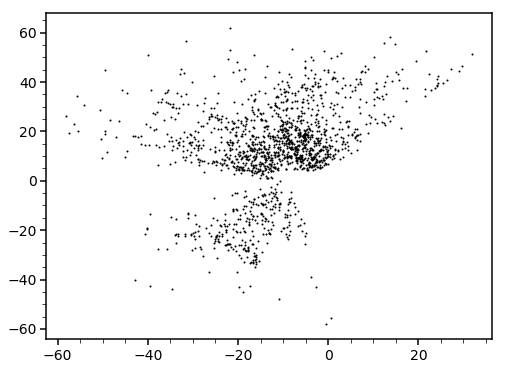

In [45]:
plt.scatter(gc1.x[sgrstars],gc1.z[sgrstars],color='black',s=1.)



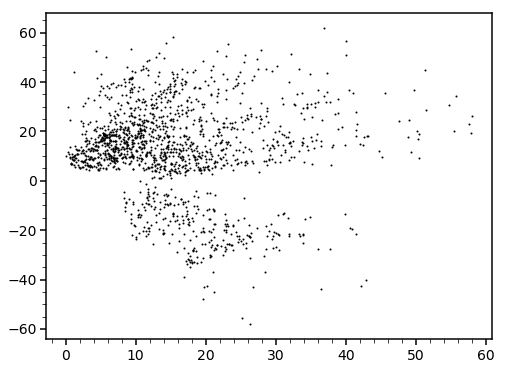

In [46]:
plt.scatter(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y)[sgrstars],gc1.z[sgrstars],color='black',s=1.)



In [47]:
# need some sort of smart tuning for the rotation curve like Bovy. 
# Where are those mclure data points?
# update: they are in fixedpotential/resonance-locations.

In [48]:
# put orbits in system units

veltrans = vcirc/1.4
veltrans = 260./1.4 # best to match MW rotation curve
scltrans = 300.


ODict = {}

for o in range(0,len(gc1.x)):
    ODict[o] = {'start_pos':[np.array(gc1.x)[o]/scltrans,np.array(gc1.y)[o]/scltrans,np.array(gc1.z)[o]/scltrans] ,\
                'start_vel':[np.array(gc1.v_x)[o]/veltrans,np.array(gc1.v_y)[o]/veltrans,np.array(gc1.v_z)[o]/veltrans]}


      
      

## Integrate orbits

Now we have the velocities that we need to be able to integrate orbits.

So many of the orbits are clearly still rotating with the disk, so it's unclear how we can claim that so many must be halo stars.

In [69]:
import modelpotential as mp

# the fiducial model
indir = '/Volumes/SIMSET/Disk001/'
runtag = 'run001s'
cachefile = '.eof.cache.file'

# use 20 to get the initial settling
F = mp.initialize_potential(indir,runtag,cachefile,timein=20,usebar=False)

# make a backup copy before modifying anything
G = copy.deepcopy(F)

Disk calculation time: 6.8 seconds
0.04000000000000003
Halo calculation time: 2.9 seconds
Total time elapsed: 9.7 seconds


In [70]:
# reduce to the monopole and first few terms

oldSL = F.SL.expcoef
newSL = np.zeros_like(F.SL.expcoef)
#print(newSL)
newSL[0,0:4] = oldSL[0,0:4]
F.SL.expcoef = newSL#np.zeros([F.SL.expcoef.shape[0],F.SL.expcoef.shape[1]])

oldcos = F.EOF.cos
newcos = np.zeros_like(oldcos)
F.EOF.sin = np.zeros_like(oldcos)
newcos[0,0:4] = oldcos[0,0:4]
F.EOF.cos = newcos

F.halofac = -(1./np.pi)



In [ ]:
# put orbits in system units

#veltrans = vcirc/1.4
veltrans = 240./1.4 # best to match MW rotation curve
scltrans = 300.


ODict = {}

for o in range(0,len(gc1.x)):
    ODict[o] = {'start_pos':[np.array(gc1.x)[o]/scltrans,np.array(gc1.y)[o]/scltrans,np.array(gc1.z)[o]/scltrans] ,\
                'start_vel':[np.array(gc1.v_x)[o]/veltrans,np.array(gc1.v_y)[o]/veltrans,np.array(gc1.v_z)[o]/veltrans]}


      
      

In [51]:
# need to verify that the Z direction is going the right way...

In [52]:
#ODict = {}
#ODict[1] = {'start_pos':[-0.00575,0.04903,-0.04004] ,'start_vel':[-1.26488,1.06353,-1.37904]}

t1 = time.time()

OLog = {}
for o in range(0,len(gc1.x)):
    if (o%100==0): print(o)
    try:
        OLog[o] = mp.int_orbit(F,ODict,o,rotfreq=0.,dt=0.0005,nint=1000,max_m =0,max_l=0,force=False)
        OLog[o]['R'] = np.sqrt(OLog[o]['X']*OLog[o]['X'] + OLog[o]['Y']*OLog[o]['Y'])
        OLog[o]['R3'] = np.sqrt(OLog[o]['X']*OLog[o]['X'] + OLog[o]['Y']*OLog[o]['Y'] + OLog[o]['Z']*OLog[o]['Z'])
        OLog[o]['VR'] = np.abs(OLog[o]['X']*OLog[o]['VX'] + OLog[o]['Y']*OLog[o]['VY'])/(OLog[o]['R'])
        OLog[o]['TH'] = np.arctan2(OLog[o]['TY'],OLog[o]['TX'])
    except:
        # also buffer this to have nans
        OLog[o] = OLog[o-1]
        OLog[o]['R3'] = np.nan*OLog[o]['R']
    #print(np.nanmin(Orbit['R']),np.nanmax(Orbit['R']))


print('Elapsed time (minutes):',(time.time()-t1)/60.)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
Elapsed time (minutes): 71.36800095240275


In [58]:
rperi = np.zeros(len(gc1.x))
rapo  = np.zeros(len(gc1.x))
zdiff = np.zeros(len(gc1.x))
zmax  = np.zeros(len(gc1.x))

for o in range(0,len(gc1.x)):
    #print(np.nanmin(OLog[o]['R3']))
    rperi[o] = np.nanmin(OLog[o]['R3'])*scltrans
    rapo[o] = np.nanmax(OLog[o]['R3'])*scltrans
    zdiff[o] = np.nanmax(OLog[o]['Z'])*np.nanmin(OLog[o]['Z'])
    zmax[o] = np.nanmax(np.abs(OLog[o]['Z']))*scltrans

In [65]:
np.array(BHB.b[0])

array(-37.5436795)

In [60]:

def jorge_galactic(x0,y0,z0,u0,v0,w0):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    dL=np.arctan(y0/x0)/f
    
    dL[(y0<0)&(x0>0.)] += 360.
    dL[(y0>0)&(x0<0.)] += 180.
    dL[(y0<0)&(x0<0.)] += 180.
    #if ((y0<0)&(x0>0.)): dL=dL+360.
    #if ((y0>0)&(x0<0.)): dL=dL+180.
    #if ((y0<0)&(x0<0.)): dL=dL+180.
    
    return dL,dB,rad,vr,dmul,dmub

In [61]:
dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(BHB.x),np.array(BHB.y),np.array(BHB.z),\
                               np.array(BHB.vx),np.array(BHB.vy),np.array(BHB.vz))

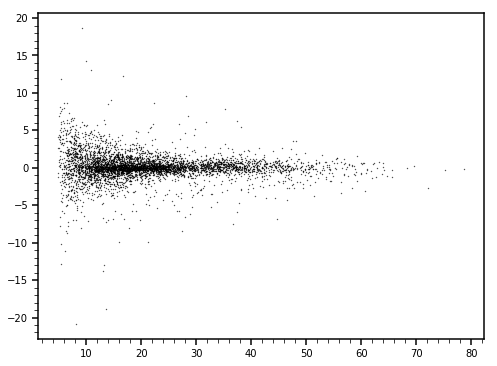

In [751]:
plt.scatter(radj,dmulj,color='black',s=0.1)

In [754]:
print(np.array(BHB.b)-dBj)

[ 1.99212852  2.17076603  2.03208416 ... -1.30181272 -2.33538575
  5.47616143]


In [755]:
# print to a file...

# with a flipped vb ONLY?



#plt.scatter(BHB.l,BHB.b,color='black',s=0.1)
"""
BHB.l
BHB.b
BHB.d
BHB.vr
BHB.vtheta <-actually phi, mislabeled
BHB.vphi <-actually theta, mislabeled
"""

#f = open('/Users/mpetersen/Downloads/BHB_Xue_full.txt','w')
f = open('/Users/mpetersen/Dropbox/mike/data/BHB_Xue_full.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; \
       vx [km/s]; vy [km/s]; vz [km/s]; \
       l [deg]; b [deg]; d [kpc]; \
       mu_l [km/s]; mu_b [km/s]; vlos [km/s]; \
       rapo [kpc]; rperi [kpc]; zmax [kpc]; \
       Sgr Lambda [deg];Sgr Beta [deg]',file=f)


targetnum = 200000
i=1000000
acc = 0
#for i in range(0,PSPDump.xpos.size):
for i in range(0,len(BHB.l)):
    
    print(np.round(np.array(BHB.x[i]),2),\
          np.round(np.array(BHB.y[i]),2),\
          np.round(np.array(BHB.z[i]),2),\
          np.round(np.array(BHB.vx[i]),2),\
          np.round(np.array(BHB.vy[i]),2),\
          np.round(np.array(BHB.vz[i]),2),\
          np.round(np.array(dLj[i]),2),\
          np.round(np.array(dBj[i]),2),\
              np.round(np.array(radj[i]),2),\
              np.round(np.array(dmulj[i]),3),\
              np.round(np.array(dmubj[i]),3),\
              np.round(np.array(vrj[i]),2),\
              np.round(rapo[i],2),\
              np.round(rperi[i],2),\
              np.round(zmax[i],2),\
              np.round(np.array(sgr.Lambda[i]),2),\
              np.round(np.array(sgr.Beta[i]),2),\
              file=f)

# dLj,dBj,radj,vrj,dmulj,dmubj
f.close()















In [728]:
# print to a file...

# with a flipped vb ONLY?



#plt.scatter(BHB.l,BHB.b,color='black',s=0.1)
"""
BHB.l
BHB.b
BHB.d
BHB.vr
BHB.vtheta <-actually phi, mislabeled
BHB.vphi <-actually theta, mislabeled
"""

#f = open('/Users/mpetersen/Downloads/BHB_Xue_full.txt','w')
f = open('/Users/mpetersen/Dropbox/mike/data/BHB_Xue_full.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; \
       vx [km/s]; vy [km/s]; vz [km/s]; \
       l [deg]; b [deg]; d [kpc]; \
       vphi [km/s]; vtheta [km/s]; vlos [km/s]; \
       rapo [kpc]; rperi [kpc]; zmax [kpc]; \
       Sgr Lambda [deg];Sgr Beta [deg]',file=f)


targetnum = 200000
i=1000000
acc = 0
#for i in range(0,PSPDump.xpos.size):
for i in range(0,len(BHB.l)):
    
    print(np.round(np.array(BHB.x[i]),2),\
          np.round(np.array(BHB.y[i]),2),\
          np.round(np.array(BHB.z[i]),2),\
          np.round(np.array(BHB.vx[i]),2),\
          np.round(np.array(BHB.vy[i]),2),\
          np.round(np.array(BHB.vz[i]),2),\
          np.round(np.array(BHB.l[i]),2),\
          np.round(np.array(BHB.b[i]),2),\
              np.round(np.array(BHB.d[i]),2),\
              np.round(np.array(BHB.vphi[i]),3),\
              np.round(np.array(BHB.vtheta[i]),3),\
              np.round(np.array(BHB.vr[i]),2),\
              np.round(rapo[i],2),\
              np.round(rperi[i],2),\
              np.round(zmax[i],2),\
              np.round(np.array(sgr.Lambda[i]),2),\
              np.round(np.array(sgr.Beta[i]),2),\
              file=f)

    
f.close()














In [723]:


In = np.genfromtxt('/Users/mpetersen/Downloads/BHB_Xue_full.txt',skip_header=1)

x = In[:,0]
y = In[:,1]
z = In[:,2]
vx = In[:,3]
vy = In[:,4]
vz = In[:,5]
l = In[:,6]
b = In[:,7]
dist = In[:,8]
vphi= In[:,9]
vtheta= In[:,10]
vlos= In[:,11]
rapo= In[:,12]
rperi= In[:,13]
zmax = In[:,14]
sLambda = In[:,15]
sBeta = In[:,10]



In [724]:
vx

array([269.29,  26.26, -98.43, ..., -56.69, -21.06, 372.46])

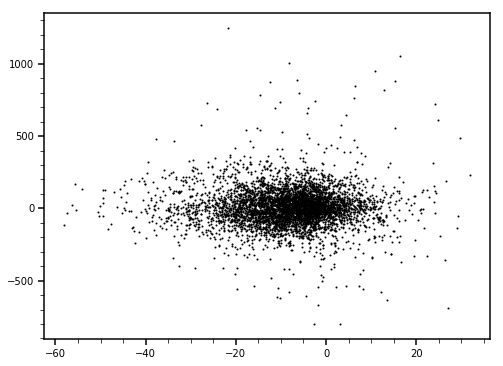

In [727]:
plt.scatter(x,vx,color='black',s=1.)

In [100]:


In = np.genfromtxt('/Users/mpetersen/Downloads/BHB_Xue.txt',skip_header=1)

l = In[:,0]
b = In[:,1]
dist = In[:,2]
vphi= In[:,3]
vtheta= In[:,4]
vlos= In[:,5]
rapo= In[:,6]
rperi= In[:,7]
zmax = In[:,8]
sLambda = In[:,9]
sBeta = In[:,10]


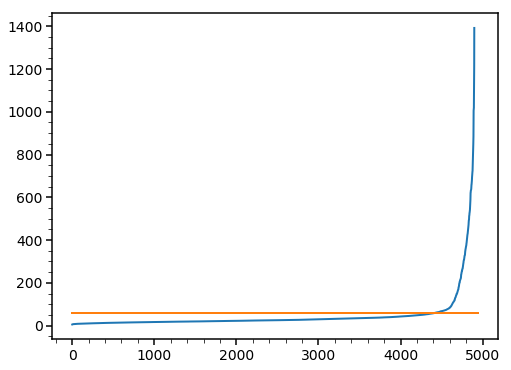

In [71]:
plt.plot(rapo[rapo.argsort()])
plt.plot([0,len(rapo)],[60.,60.])

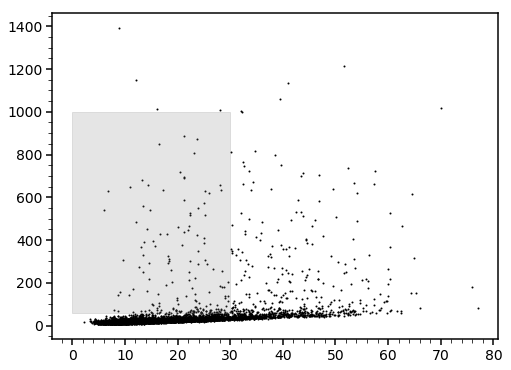

In [73]:
plt.scatter(dist,rapo,s=1.,color='black')
plt.fill_between([0.,30.],[60.,60.],[1000,1000],color='gray',alpha=0.2)

In [76]:
dcut = np.where((rapo>50.)&(dist<30.))[0]
print(dcut.size)

161


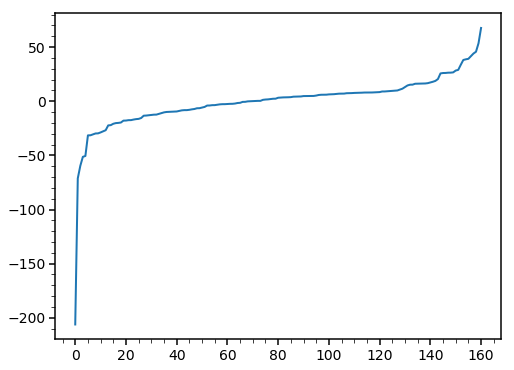

In [91]:
plt.plot(vtheta[dcut][vtheta[dcut].argsort()])

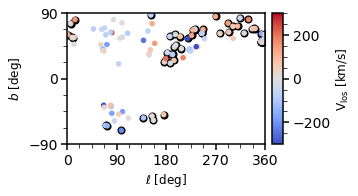

In [350]:
#velstretch = 

fig = plt.figure(figsize=(5,2.5))
ax1 = fig.add_axes([0.19,0.23,0.55,0.73])
ax2 = fig.add_axes([0.76,0.23,0.03,0.73])


rapomax = 50.
dcut2 = np.where((rapo>rapomax)&(dist<30.)&(np.abs(sBeta)<15.))[0]
dcut2 = np.where((rapo>rapomax)&(np.abs(sBeta)<15.))[0]
dcut2 = np.where((dist>rapomax)&(np.abs(sBeta)<15.))[0]


l[l<0]+=360.

ax1.scatter(l[dcut2],b[dcut2],color='black',s=50.)

dcut = np.where((rapo>rapomax)&(dist<30.))[0]
dcut = np.where((rapo>rapomax))[0]#&(dist<30.))[0]
dcut = np.where((dist>rapomax))[0]#&(dist<30.))[0]



ax1.scatter(l[dcut],b[dcut],color=cm.coolwarm((vlos[dcut]+300.)/600.,1.),s=20.)

#ax1.scatter(l[dcut],b[dcut],color=cm.coolwarm((vtheta[dcut]+100.)/200.,1.),s=20.)
#ax1.scatter(l[dcut],b[dcut],color=cm.coolwarm((vphi[dcut]+100.)/200.,1.),s=20.)


ax1.set_xlabel('$\ell$ [deg]',size=12)
ax1.set_ylabel('$b$ [deg]',size=12)
ax1.set_xticks([0.,90.,180.,270.,360.])
ax1.set_yticks([-90.,0.,90.])
ax1.axis([0.,360.,-90.,90.])

norm = mpl.colors.Normalize(vmin=-300, vmax=300)
#norm = mpl.colors.Normalize(vmin=-150, vmax=150)

#cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,norm=norm)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cm.coolwarm,norm=norm)#,orientation='horizontal',ticklocation='top')
cb1.set_label('V$_{\\rm los}$ [km/s]',size=12)
#cb1.set_label('V$_{\\theta}$ [km/s]',size=12)
#cb1.set_label('V$_{\\phi}$ [km/s]',size=12)




#plt.tight_layout()
#plt.savefig('/Users/mpetersen/Downloads/BHBstars_theta.png',dpi=300)


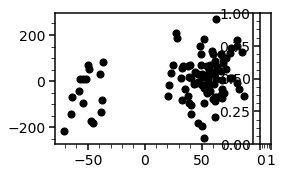

In [352]:

fig = plt.figure(figsize=(5,2.5))
ax1 = fig.add_axes([0.19,0.23,0.55,0.73])
ax2 = fig.add_axes([0.76,0.23,0.03,0.73])


rapomax = 50.
dcut2 = np.where((rapo>rapomax)&(dist<30.)&(np.abs(sBeta)<15.))[0]
dcut2 = np.where((rapo>rapomax)&(np.abs(sBeta)<15.))[0]
dcut2 = np.where((dist>rapomax))[0]#&(np.abs(sBeta)<15.))[0]


l[l<0]+=360.

ax1.scatter(b[dcut2],vlos[dcut2],color='black',s=50.)



In [171]:
metalvals = bhbcat['feh']

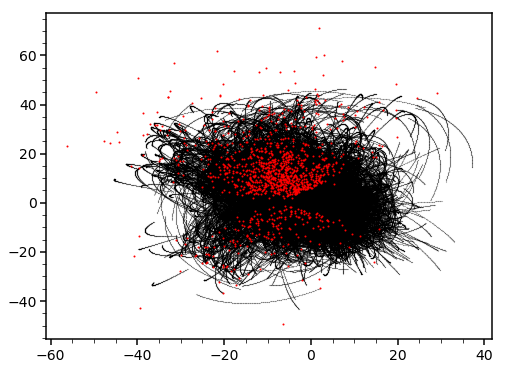

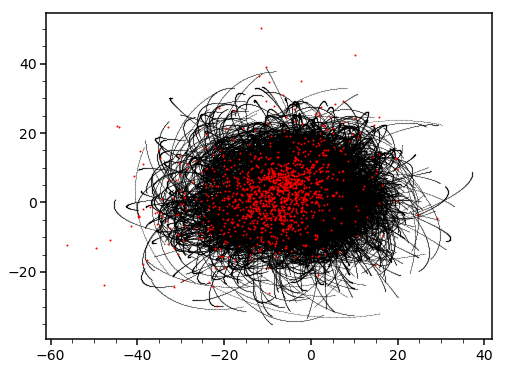

In [172]:
plt.figure()

lenscale=300.

for o in range(0,len(gc1.x)):
    if (rapo[o] < 50.):# & (gaiadic[o] < -2.):
        plt.scatter(lenscale*OLog[o]['X'][0:200],lenscale*OLog[o]['Z'][0:200],color='black',s=0.01)
    
    
plt.scatter(gc1.x[metalvals < -2.],gc1.z[metalvals < -2.],color='red',s=1.)


plt.figure()

lenscale=300.

for o in range(0,len(gc1.x)):
    if (rapo[o] < 50.):# & (metalvals[o] < -2.):
        plt.scatter(lenscale*OLog[o]['X'][0:200],lenscale*OLog[o]['Y'][0:200],color='black',s=0.01)
    
    
plt.scatter(gc1.x[metalvals < -2.],gc1.y[metalvals < -2.],color='red',s=1.)

In [182]:
rapo.size*0.12

593.28

(0.0, 100.0)

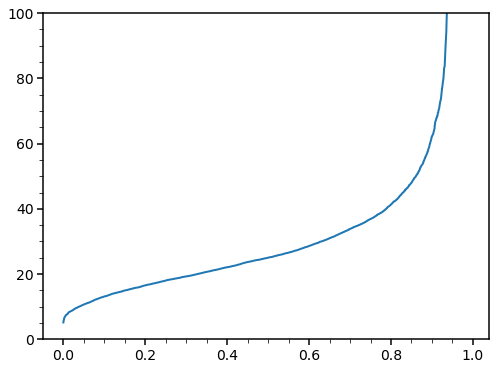

In [180]:
plt.plot(np.linspace(0.,1.,rapo.size),rapo[rapo.argsort()])
plt.ylim(0.,100.)


In [176]:
eccen = (rapo-rperi)/(rapo+rperi)

print(np.nanmean(rapo[metalvals>-1.5]))
print(np.nanmean(rapo[(metalvals<-2.) & (eccen>0.9) & (rapo<50.)]))
print(np.nanstd(rapo[(metalvals<-2.) & (eccen>0.9) & (rapo<50.)]))

65.59869863013698
24.349090909090908
9.785017003532099


## Appendix 1: Executed Queries

In [483]:

##Table1
#objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid

C = np.genfromtxt('/Users/mpetersen/Downloads/Skyserver_Radial4_4_2020 11_14_36 PM.csv',\
                 dtype={'names': ("objid","ra","dec",\
                                         "u","g","r","i","z",\
                                         "run","rerun","camcol","field",\
                                         "specobjid","class","redshift",\
                                         "plate","mjd","fiberid"),\
                             'formats': ('S20','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'S20','S20','f8',\
                                        'i4','i4','i4')},\
                 skip_header=2,delimiter=',')


In [608]:
# segue is 1660/3480

segue = np.where( (C['plate']>1660) & (C['plate']<3480))[0]
segue = np.where( (C['plate']>266) & (C['plate']<3006))[0]


print(segue.size)


10378


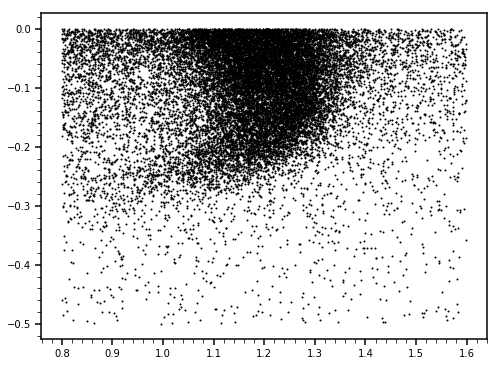

In [484]:
C['class'][C['class']==b'STAR'].size

gr = C['g']-C['r']
ug = C['u']-C['g']
w = np.where(C['class']==b'STAR')[0]
plt.scatter(ug[w],gr[w],color='black',s=1.)

In [610]:
def print_file_name(indx,file):
    #print(C['plate'][indx].decode()+'/spec-'+C['plate'][indx].decode()+\
    #                               '-'+C['mjd'][indx].decode()+\
    #                               '-'+C['fiberid'][indx].decode()+'.fits')

    print('{0:04d}/spec-{1:04d}-{2}-{3:04d}.fits'.format(C['plate'][indx],\
                                                 C['plate'][indx],\
                                                 C['mjd'][indx],\
                                                 C['fiberid'][indx]),file=file)


f = open('/Users/mpetersen/Downloads/SEGUE/fullspec.txt','w')
for i in range(0,segue.size):
    print_file_name(segue[i],file=f)
    
f.close()

#/usr/local/Cellar/wget/1.20.3_2/bin/wget -i fullspec.txt -B http://data.sdss3.org/sas/dr9/sdss/spectro/redux/26/spectra/



failed for /Users/mpetersen/Downloads/SEGUE/spec-0701-52179-0443.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0755-52235-0259.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0772-52375-0091.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0802-52289-0423.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0803-52318-0598.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0827-52312-0523.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0852-52375-0017.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0885-52379-0494.fits


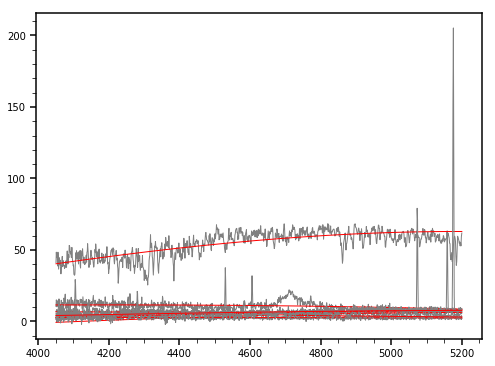

In [652]:
# prototyper for when things are stuck:


for indx,infile in enumerate(F[400:500]):
    
    hdul = fits.open(infile)

    data = np.array(hdul[1].data)

    wave = 10.**(data['loglam'])
    flux = data['flux']
    outwave,outflux = normalise_continuum(wave,flux)
    
    #

    try:
        fms[indx],D02s[indx],bs[indx],cs[indx] = fit_hgamma(outwave,outflux)
    except:
        print('failed for {}'.format(infile))
        outwave,outflux,fitflux = normalise_continuum(wave,flux,diagnostic=True)
        plt.plot(outwave,outflux,color='gray',lw=1.)
        plt.plot(outwave,fitflux,color='red',lw=1.)





In [702]:
import glob

F = glob.glob('/Users/mpetersen/Downloads/SEGUE/*.fits')


HG = {}
HG['fms'] = np.zeros(len(F))
HG['D02s'] = np.zeros(len(F))
HG['cs'] = np.zeros(len(F))
HG['bs'] = np.zeros(len(F))
HG['x0s'] = np.zeros(len(F))
HG['efms'] = np.zeros(len(F))
HG['eD02s'] = np.zeros(len(F))
HG['ecs'] = np.zeros(len(F))
HG['ebs'] = np.zeros(len(F))
HG['ex0s'] = np.zeros(len(F))

HD = {}
HD['fms'] = np.zeros(len(F))
HD['D02s'] = np.zeros(len(F))
HD['cs'] = np.zeros(len(F))
HD['bs'] = np.zeros(len(F))
HD['x0s'] = np.zeros(len(F))

import warnings
warnings.simplefilter('ignore', np.RankWarning)

f = open('/Users/mpetersen/Downloads/SEGUE/allrejected.txt','w')

for indx,infile in enumerate(F):
    
    hdul = fits.open(infile)

    data = np.array(hdul[1].data)

    wave = 10.**(data['loglam'])
    flux = data['flux']
    outwave,outflux = normalise_continuum(wave,flux)
    
    #plt.plot(outwave,outflux)

    badflag = 0
    try:
        #fms[indx],D02s[indx],bs[indx],cs[indx] = fit_hdelta(outwave,outflux)

        
        HG['fms'][indx],HG['D02s'][indx],HG['bs'][indx],HG['cs'][indx],HG['x0s'][indx],\
        HG['efms'][indx],HG['eD02s'][indx],HG['ebs'][indx],HG['ecs'][indx],HG['ex0s'][indx] = fit_hgamma(outwave,outflux)
    except:
        
        # from testing above, it's fairly clear that the failures result from non-stellar sources.
        # so what are they?? might need to look into that
        badflag += 1
        
    try:
        HD['fms'][indx],HD['D02s'][indx],HD['bs'][indx],HD['cs'][indx],HD['x0s'][indx] = fit_hdelta(outwave,outflux)

    except:
        badflag += 1
    
    if badflag==2:
        # print obviously bad files so that we can eliminate them for space considerations

        print(infile,file=f)


f.close()

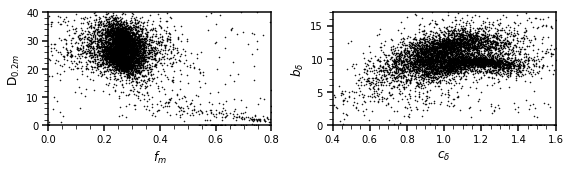

In [700]:

# h delta plot
fig = plt.figure(figsize=(8,2.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(HD['fms'],HD['D02s'],color='black',s=0.3)
ax1.axis([0.,0.8,0.,40.])
ax1.set_xlabel('$f_m$',size=12)
ax1.set_ylabel('D$_{0.2m}$',size=12)

ax2.scatter(HD['cs'],HD['bs'],color='black',s=0.3)
ax2.axis([0.4,1.6,0.,17.])
ax2.set_xlabel('$c_\delta$',size=12)
ax2.set_ylabel('$b_\delta$',size=12)

fig.tight_layout()

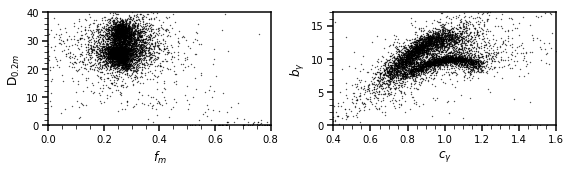

In [699]:

# h gamma plot
fig = plt.figure(figsize=(8,2.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(HG['fms'],HG['D02s'],color='black',s=0.1)
ax1.axis([0.,0.8,0.,40.])
ax1.set_xlabel('$f_m$',size=12)
ax1.set_ylabel('D$_{0.2m}$',size=12)

ax2.scatter(HG['cs'],HG['bs'],color='black',s=0.1)
ax2.axis([0.4,1.6,0.,17.])
ax2.set_xlabel('$c_\gamma$',size=12)
ax2.set_ylabel('$b_\gamma$',size=12)

fig.tight_layout()

[-600, 600, -600, 600]

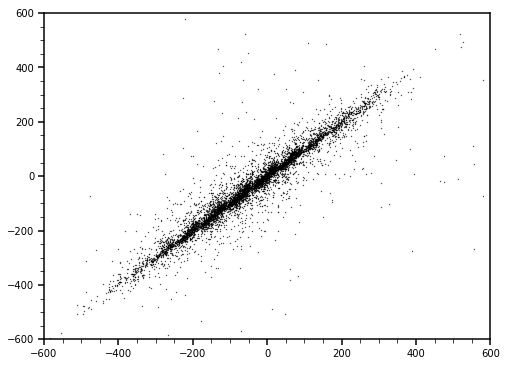

In [701]:
velocitiesHG = speed_of_light*(HG['x0s']-balmer['gamma'])/balmer['gamma']
velocitiesHD = speed_of_light*(HD['x0s']-balmer['delta'])/balmer['delta']


plt.scatter(velocitiesHG,velocitiesHD,color='black',s=0.1)
plt.axis([-600,600,-600,600])


(-600.0, 600.0)

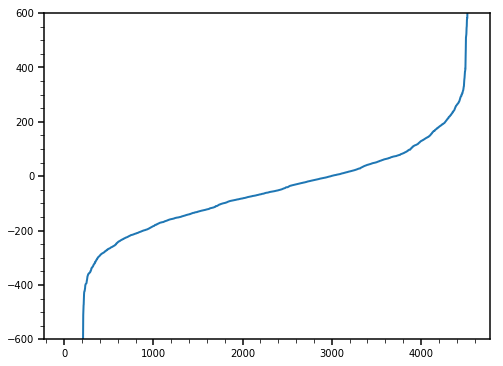

In [688]:
plt.plot(velocities[velocities.argsort()])
plt.ylim(-600.,600.)

In [500]:

hdul.info()

Filename: /Users/mpetersen/Downloads/SEGUE/spec-2047-53732-0552.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3831R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   
  4  B2-00035942-00035940-00035941    1 BinTableHDU    146   2047R x 7C   [E, E, E, J, E, E, E]   
  5  B2-00035943-00035940

In [593]:
print(data['ivar'])
print(data['flux'])

[0.02843923 0.03051122 0.03058311 ... 0.45608446 0.43514284 0.41500518]
[100.01546   99.661964  98.72565  ...  18.909353  18.134226  14.046533]


In [675]:
balmer = {}
balmer['alpha'] = 6563.
balmer['beta'] = 4861.
balmer['gamma'] = 4341.692
balmer['delta'] = 4102.892


In [648]:
data.shape
#plt.plot(,data['flux'])
#plt.xlim(3000.,5000.)



def normalise_continuum(wave,flux,diagnostic=False):
    ww = np.where( ((wave>4200) & (wave<4300)) |\
                  ((wave>4400) & (wave<4800)) |\
                  ((wave>4950) & (wave<5500)))
    
    w = np.where((wave>4050) & (wave<5200))
    p = np.polyfit(wave[ww],flux[ww],4)
    pfunc = np.poly1d(p)

    if diagnostic:
        return wave[w],flux[w],pfunc(wave[w])
        
    else:
        return wave[w],flux[w]/pfunc(wave[w])


infile = '/Users/mpetersen/Downloads/SEGUE/spec-2047-53732-0552.fits'
hdul = fits.open(infile)
data = np.array(hdul[1].data)


wave = 10.**(data['loglam'])
flux = data['flux']
outwave,outflux = normalise_continuum(wave,flux)

fm,D02,b,c = fit_hgamma(outwave,outflux)



#plt.plot(wave[w],flux[w],color='black')
#plt.plot(wave[w],pfunc(wave[w]),color='red')
#plt.plot(outwave,outflux,color='red')
#plt.plot([np.nanmin(wave[w]),np.nanmax(wave[w])],[1.,1.],color='gray',linestyle='dashed')

In [590]:
def sersic(x,a,b,c,x0,level=1.):
    
    return level - a*np.exp(- (np.abs(x-x0)/b)**c)
    

In [695]:

from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.optimize import brentq




def fit_hdelta(wave,flux):
    
    hdelta = np.where( (wave>4050) & (wave<4200))

    popt, pcov = curve_fit(sersic, wave[hdelta],flux[hdelta],p0=(0.8,10.,1.,4102.))

    fm = 1.-popt[0]
    b = popt[1]
    c = popt[2]
    x0 = popt[3]
    
    loroot = brentq(sersic,0,popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))
    hiroot = brentq(sersic,popt[3],2.*popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))

    D02 = hiroot - loroot
    
    return fm,D02,b,c,x0




def fit_hgamma(wave,flux,error=True):
    
    hgamma = np.where( (wave>4250) & (wave<4450))

    popt, pcov = curve_fit(sersic, wave[hgamma],flux[hgamma],p0=(0.8,10.,1.,4350.))

    
    fm = 1.-popt[0]
    b = popt[1]
    c = popt[2]
    x0 = popt[3]

    perr = np.sqrt(np.diag(pcov))
    efm = perr[0]
    eb = perr[1]
    ec = perr[2]
    ex0 = perr[3]
    
    loroot = brentq(sersic,0,popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))
    hiroot = brentq(sersic,popt[3],2.*popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))

    D02 = hiroot - loroot
    
    loroot = brentq(sersic,0,popt[3],args=(popt[0]-perr[0],popt[1]-perr[1],popt[2]-perr[2],popt[3]-perr[3],0.2))
    hiroot = brentq(sersic,popt[3],2.*popt[3],args=(popt[0]-perr[0],popt[1]-perr[1],popt[2]-perr[2],popt[3]-perr[3],0.2))

    # need to figure out if this is a good error estimate...
    eD02 = hiroot - loroot

    if error:
        return fm,D02,b,c,x0,efm,eD02,eb,ec,ex0
    
    else:
        return fm,D02,b,c,x0


#plt.plot(wave[hgamma],flux[hgamma]/pfunc(wave[hgamma]),color='black')
#plt.plot([np.nanmin(wave[hgamma]),np.nanmax(wave[hgamma])],[1.,1.],color='gray',linestyle='dashed')


speed_of_light = 3.e5 # in km/s

fm,D02,b,c,x0,efm,eD02,eb,ec,ex0 = fit_hgamma(outwave,outflux)
print('fm={0:3.3f}'.format(fm))
print('D02={0:3.2f}'.format(D02))
print(speed_of_light*(x0-balmer['gamma'])/balmer['gamma'])

fm,D02,b,c,x0 = fit_hdelta(outwave,outflux)
print('fm={0:3.3f}'.format(fm))
print('D02={0:3.2f}'.format(D02))
print(speed_of_light*(x0-balmer['delta'])/balmer['delta'])




fm=0.210
D02=24.08
-40.79962418201576
fm=0.211
D02=20.72
8.219117459834155


In [696]:
print(efm)

0.07560577312284351


Note that I seem to have lost the technology to upload tables with source_id for matching. ra/dec seems possible?